## Importing libraries & initial parameters

In [ ]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display
from scipy.optimize import curve_fit
%matplotlib inline

In [ ]:
length = 80
cars = 20
time = 50
probability_slow_down = 0
maximum_velocity = 5
probability_new_car = 1

## Single lane rules and functions

In [ ]:
def create_road(length, cars):
    road = np.full(shape=length, fill_value=-1, dtype=np.int)
    counter = 0
    all_positions = np.array([])
    while counter < cars:
        position = random.randint(length)
        if position not in all_positions[:]:
            road[position] = random.randint(1, maximum_velocity+1)
            counter += 1
        all_positions = np.append(all_positions, position)
    return road

In [ ]:
def space_infront(road, car_velocity, position): 
    if car_velocity == -1:
        return 0
    else:
        distance_counter = 0
        found_car = 0
        while found_car == 0:
            distance_counter += 1
            try:
                if road[position + distance_counter] >= 0:
                    found_car = 1
            except IndexError:
                if road[position + distance_counter - len(road)] >= 0:
                    found_car = 1

        return distance_counter

In [ ]:
def flow_against_density(lengths, maximum_velocity, probability_slow_down, graph):
    if graph:
        plt.figure(figsize = (30,10))
        plt.rc('xtick', labelsize=20)
        plt.rc('ytick', labelsize=20)
    maximum_car_movements=np.array([])
    maximum_densities=np.array([])
    for length_road in lengths:
        t=0
        cars_list = np.arange(1,length_road+1)
        cars_per_second = []
        for cars in cars_list:
          t=0
          road = create_road(length_road, cars)
          total_car_distance = 0
          while t < time:
            #changing velocities
                accelerated_road = acceleration_phase(road, maximum_velocity)
                slowed_road = slowing_phase(accelerated_road)
                randomised_road = randomise_phase(slowed_road, probability_slow_down)
            #moving phase
                final_road = moving_phase(randomised_road, length_road)
            #updating step
                t += 1
                road = final_road
                for velocity in road:
                    if velocity > 0:
                        total_car_distance += velocity
          cars_per_second.append(total_car_distance/(time))
        if graph:
            plt.scatter(cars_list/length_road, cars_per_second, label=length_road)
        
#sets the parameters for fitting the curve (both must be integers)
        left_of_peak = int(length_road/25)
        right_of_peak = int(length_road/5)
#selects relevant data and fits a 4th degree polynomial
        data_near_peak = cars_per_second[left_of_peak:right_of_peak]
        density_near_peak = cars_list[left_of_peak:right_of_peak] / length_road
        fit = np.polyfit(density_near_peak, data_near_peak, 4)
#creates a large number of density values near peak to graph the fit
        density_values = np.arange(left_of_peak/length_road, right_of_peak/length_road, 0.001)
        fit_line = (fit[4] + (density_values*fit[3]) + ((density_values**2)*fit[2]) + 
                    ((density_values**3)*fit[1]) + ((density_values**4)*fit[0]))
        if graph:
            plt.plot(density_values, fit_line)
#from the fit finds the density of cars and the flow of cars at the maximum
        maximum_car_movements = np.append(maximum_car_movements, np.max(fit_line)/length_road)
        location_maximum = (fit_line.argmax()*0.001) + (left_of_peak/length_road)
        maximum_densities = np.append(maximum_densities, location_maximum)

    if graph:
        plt.title("Total Car Movement / Second", {'fontsize':30})
        plt.xlabel("Density", {'fontsize':30})
        plt.ylabel("Car movement per time step", {'fontsize':30})
        plt.legend(title="Length of road:", fontsize=20, title_fontsize=25)
        plt.show()

    return [maximum_car_movements, maximum_densities]


## Single lane phases

In [ ]:
def acceleration_phase(road, maximum_velocity):
    for position, car_velocity in enumerate(road[:]):
        if -1 < car_velocity < maximum_velocity and space_infront(road, car_velocity, position) > (car_velocity + 1):
            road[position] = road[position] + 1
    return road

In [ ]:
def slowing_phase(road):
    for position, car_velocity in enumerate(road[:]):
        if space_infront(road, car_velocity, position) <= car_velocity:
            road[position] = space_infront(road, car_velocity, position) - 1
    return road

In [ ]:
def randomise_phase(road, probability_slow_down):
    for position, car_velocity in enumerate(road[:]):
        if car_velocity > 0:
            if np.random.uniform(0, 1) < probability_slow_down:
                road[position] = road[position] - 1
    return road

In [ ]:
def moving_phase(road, length_road, loop=True):
  new_road = np.full(shape=length_road, fill_value=-1, dtype=np.int) #First creates an empty road.

  if loop == False:
    new_road[0] = 0
    cars_moved = 0
    for position, car_velocity in enumerate(road[:]):
        try:
            if car_velocity >= 0:
              new_road[position + car_velocity] = road[position]
        except IndexError:
          pass
    new_road[-2:] = -1
      

  else:
    new_road[0] = -1
    cars_moved = 0
    for position, car_velocity in enumerate(road[:]):
        try:
            if car_velocity >= 0:
              new_road[position + car_velocity] = road[position]
        except IndexError:
          new_road[position + car_velocity - len(road)] = car_velocity

  return new_road

## Simulating single lane road

In [ ]:
road = create_road(length, cars) #This makes the initial road setup. 
t = 0
all_roads = np.array([]) #This array is used to store all of the roads (after every movement)
empty_road = np.empty(length)
empty_road.fill(-1)
all_roads = np.append(all_roads, empty_road) #starts with an empty road (to all vstack)
while t < time:
#changing velocities
     accelerated_road = acceleration_phase(road, maximum_velocity)
     slowed_road = slowing_phase(accelerated_road)
     randomised_road = randomise_phase(slowed_road, probability_slow_down)
     all_roads = np.vstack((all_roads, randomised_road)).astype(int)
  #moving phase
     final_road = moving_phase(randomised_road, length, loop=False)
  #updating step
  #   all_roads = np.vstack((all_roads, final_road)).astype(int)
     t += 1
     road = final_road
all_roads = np.delete(all_roads, (0), axis=0) #deletes first empty row

In [ ]:
t=0
cars_list = np.arange(1,length+1)
average_movement = []
percentage_movement = []
for cars in cars_list:
  t=0
  road = create_road(length, cars)
  movement = 0
  while t < time:
    #changing velocities
        accelerated_road = acceleration_phase(road, maximum_velocity)
        slowed_road = slowing_phase(accelerated_road)
        randomised_road = randomise_phase(slowed_road, probability_slow_down)
    #moving phase
        final_road = moving_phase(randomised_road, length, loop=False)
    #updating step
        t += 1
        road = final_road
        movement += np.sum(np.bincount(road+1)[2:])

  average_movement.append(movement/time)
  percentage_movement.append(movement/(time*np.sum(np.bincount(road+1)[1:])))

## Creating plots

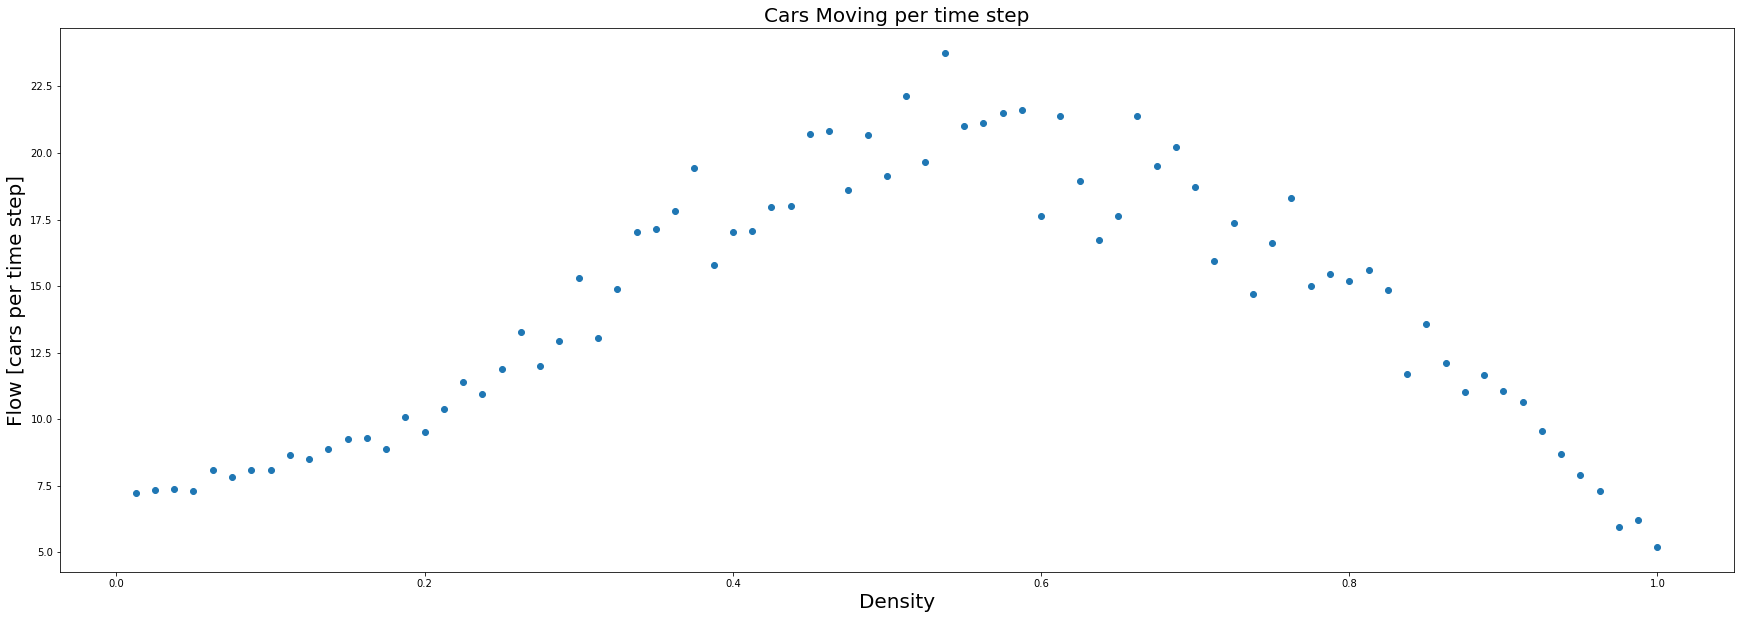

In [ ]:
plt.figure(figsize = (30,10))
plt.scatter(cars_list/length, average_movement)
plt.title("Cars Moving per time step", {'fontsize':20})
plt.xlabel("Density", {'fontsize':20})
plt.ylabel("Flow [cars per time step]", {'fontsize':20})
plt.show()

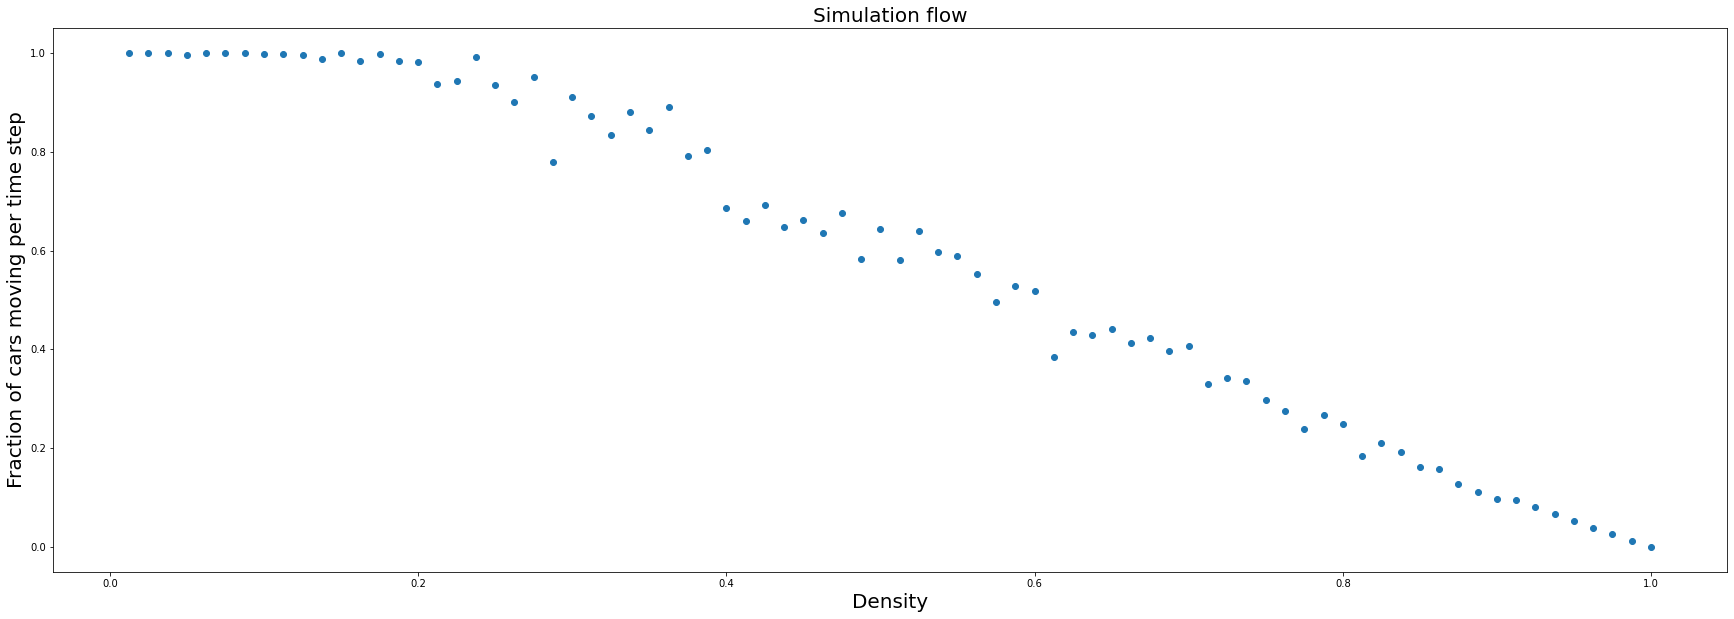

In [ ]:
plt.figure(figsize = (30,10))
plt.scatter(cars_list/length, percentage_movement)
plt.title("Simulation flow", {'fontsize':20})
plt.xlabel("Density", {'fontsize':20})
plt.ylabel("Fraction of cars moving per time step", {'fontsize':20})
plt.show()

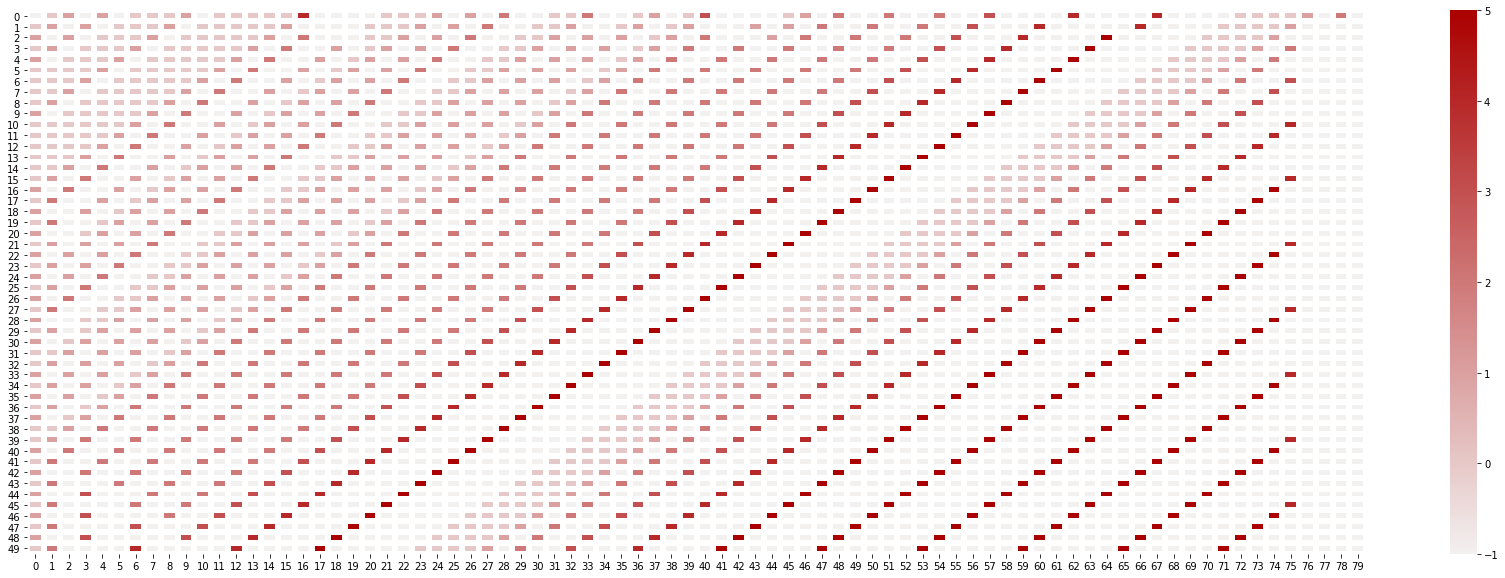

In [ ]:
%matplotlib inline
plt.figure(figsize = (30,10))
cmap = sns.light_palette("#ab0000", as_cmap=True)
sns.heatmap(data=all_roads, linewidth=5, cmap=cmap)
plt.show()

In [ ]:
# %matplotlib notebook
# fig = plt.figure(figsize=(15,0.5))
# ax = fig.add_subplot(111)
# cmap = sns.light_palette("#ab0000", as_cmap=True)
# ax = sns.heatmap(data=all_roads[0:1], linewidth=10, cmap=cmap,cbar=False, yticklabels=False)
# plt.show()


# def update_plot(step = 0):
#     ax = sns.heatmap(data=all_roads[step:step+1], linewidth=10, cmap=cmap, cbar=False, yticklabels=False)
#     fig.canvas.draw_idle()

# # widgets
# step_slider = widgets.IntSlider(0, min = 0, max = time-1)
# step_label = widgets.Label(value = 'Step number: ' + str(step_slider.value+1))
# display(step_slider, step_label)

# # handle step update
# def update_step(value):
#     update_plot(step = value['new'])
#     step_label.value = 'Step: ' + str(value.new)

# step_slider.observe(update_step, names = 'value')

<IPython.core.display.Javascript object>

IntSlider(value=0, max=49)

Label(value='Step number: 1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
lengths = [50, 100, 150, 200]

[maximum_car_movements, maximum_densities] = flow_against_density(lengths, maximum_velocity,
                                                                  probability_slow_down, True)
average_max_movement = np.average(maximum_car_movements)
error_max_movement = np.std(maximum_car_movements)
average_max_density = np.average(maximum_densities)
error_max_density = np.std(maximum_densities)

print("Maximum traffic volume / length of road: {:2.3f} \u00B1 {:2.3f}".format(
    average_max_movement, error_max_movement))
print("Density of cars at this maxmimum: {:2.3f} \u00B1 {:2.3f}".format(
    average_max_density, error_max_density))

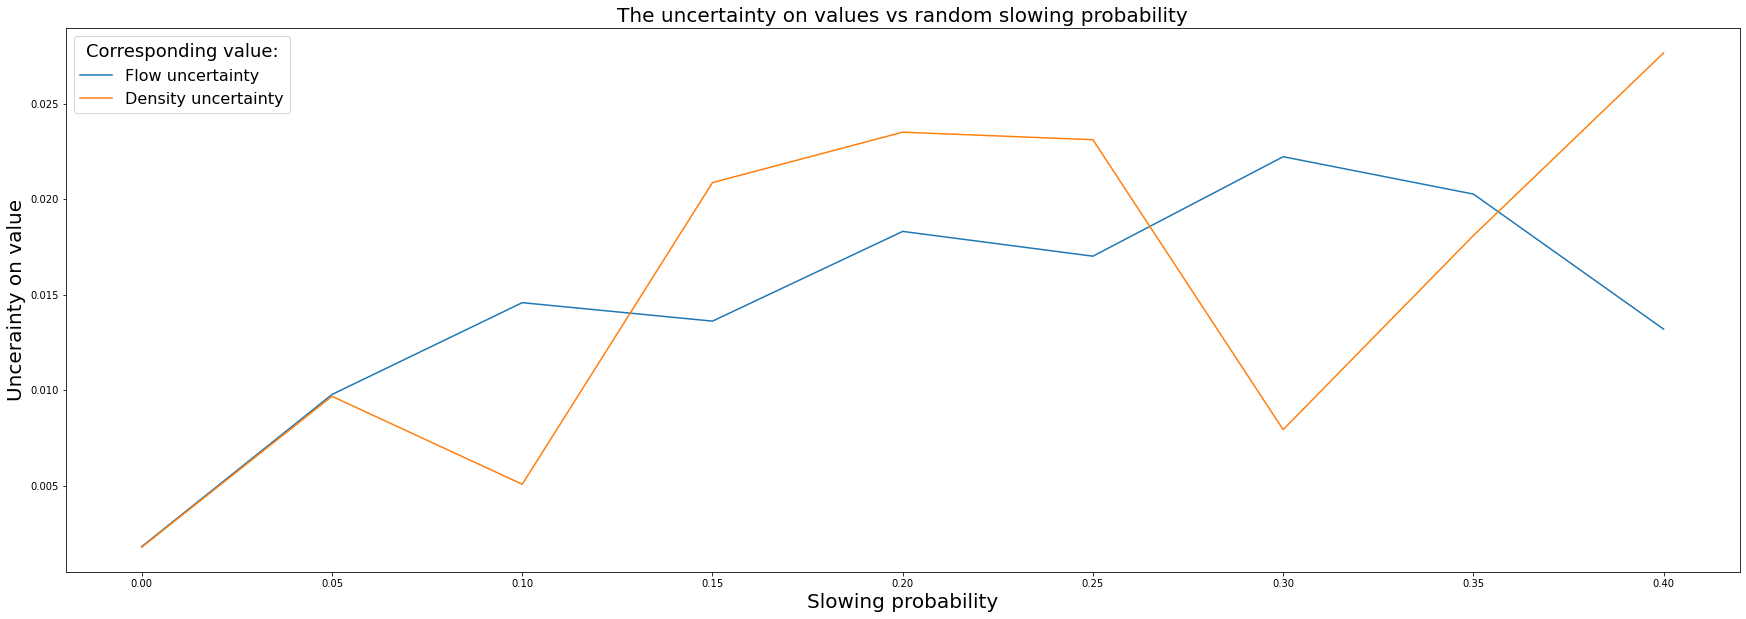

In [ ]:
#analysis of how the uncertainty on the values describing max. flow changes with prob. of slowing down
slow_down_probabilities = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
density_uncertainties = []
maximum_flow_uncertainties = []
for probability in slow_down_probabilities:
    [maximum_car_movements, maximum_densities] = flow_against_density(
        [100, 100, 100, 100, 100, 100], 
        maximum_velocity, probability, False)
    flow_uncertainty = np.std(maximum_car_movements)
    density_uncertainty = np.std(maximum_densities)
    maximum_flow_uncertainties = np.append(maximum_flow_uncertainties, flow_uncertainty)
    density_uncertainties = np.append(density_uncertainties, density_uncertainty)

plt.figure(figsize = (30,10))
plt.plot(slow_down_probabilities, maximum_flow_uncertainties, label='Flow uncertainty')
plt.plot(slow_down_probabilities, density_uncertainties, label='Density uncertainty')
plt.title("The uncertainty on values vs random slowing probability", {'fontsize':20})
plt.xlabel("Slowing probability", {'fontsize':20})
plt.ylabel("Uncerainty on value", {'fontsize':20})
plt.legend(title="Corresponding value:", fontsize=16, title_fontsize=18)
plt.show()

## Double lane

In [ ]:
def create_double(length, cars_num):

    road = np.full(shape=[2,length], fill_value=-1, dtype=np.int)
    cars = cars_num

    for lane in range(2):

      road[lane] = create_road(length, cars)
      
    return road

##Double lane phases

In [ ]:
def acceleration_double(road, maximum_velocity):
  road_new = np.full(shape=[2,length], fill_value=-1, dtype=np.int)

  for lane in range(2):
    road_new[lane] = acceleration_phase(road[lane], maximum_velocity)
    
  return road_new

In [ ]:
def lane_change(road):
  road_new = np.full(shape=[2,length], fill_value=-1, dtype=np.int)

  for lane in range(2):

    for position, car_velocity in enumerate(road[lane,:]):
      
      space = space_infront(road[lane], car_velocity, position)
      required_space = int(space/2) #min space in front of the car after changing the lane
      
      if car_velocity == -1:
        pass

      elif position == 0:
        road_new[lane, position] = car_velocity
        
      elif lane == 1:
          if space <= car_velocity and all(road[0, position-1:position+required_space+1] == -1):
              road_new[0, position] = car_velocity
          else:
             road_new[lane, position] = car_velocity
             
      elif lane == 0:
          if space <= car_velocity and all(road[1, position-1:position+required_space+1] == -1):
              road_new[1, position] = car_velocity
          else:
             road_new[lane, position] = car_velocity

  return road_new

In [ ]:
def slowing_double(road):
    road_new = np.full(shape=[2,length], fill_value=-1, dtype=np.int)

    for lane in range(2):
      road_new[lane] = slowing_phase(road[lane])
      
    return road_new

In [ ]:
def randomise_double(road, probability_slow_down):
  road_new = np.full(shape=[2,length], fill_value=-1, dtype=np.int)

  for lane in range(2):
    road_new[lane] = randomise_phase(road[lane], probability_slow_down)
    
  return road_new

In [ ]:
def moving_double(road, length_road, loop):
    road_new = np.full(shape=[2,length], fill_value=-1, dtype=np.int)
    
    for lane in range(2):
      road_new[lane] = moving_phase(road[lane], length_road, loop)

    return road_new

## Simulating two lanes

In [ ]:
road = create_double(length, cars) #This makes the initial road setup. 
t = 0
all_roads = np.array([]) #This array is used to store all of the roads (after every movement)
empty_road = np.empty(length)
empty_road.fill(-1)
all_roads = np.append(all_roads, empty_road) #starts with an empty road (to all vstack)

while t < time:

#changing velocities
     changed_road = lane_change(road)
     accelerated_road = acceleration_double(changed_road, maximum_velocity)
     slowed_road = slowing_double(accelerated_road)
     randomised_road = randomise_double(slowed_road, probability_slow_down)
     all_roads = np.vstack((all_roads, randomised_road)).astype(int)

     print("Step:", t)
     print("First lane cars:", sum(np.bincount(changed_road[0]+1)[1:]))
     print("Second lane cars:", sum(np.bincount(changed_road[1]+1)[1:]))

#moving phase
     final_road = moving_double(randomised_road, length, loop=True)

#updating step
     t += 1
     road = final_road

all_roads = np.delete(all_roads, (0), axis=0) #deletes first empty row

all_roads = np.vsplit(all_roads, time)

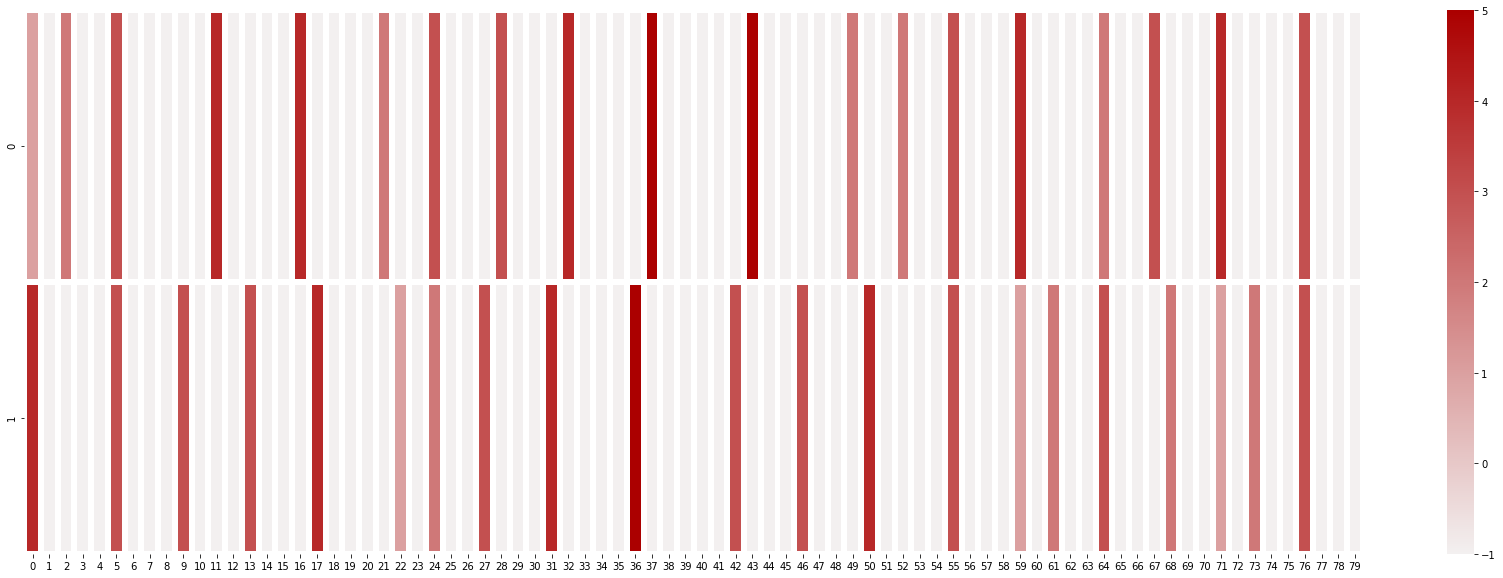

In [ ]:
%matplotlib inline
plt.figure(figsize = (30,10))
cmap = sns.light_palette("#ab0000", as_cmap=True)
sns.heatmap(data=all_roads[20], linewidth=5, cmap=cmap)
plt.show()

In [ ]:
def flow_against_density(lengths, maximum_velocity, probability_slow_down, graph):
    if graph: 
        plt.figure(figsize=(30,10))
    maximum_car_movements=np.array([])
    maximum_densities=np.array([])
    for length in lengths:
        t=0
        cars_list = np.arange(1,length+1)
        cars_per_second = []
        for cars in cars_list: 
            t=0
            road = create_double(length, cars)
            total_car_distance = 0
            while t < time:
        #changing velocities
                changed_road = lane_change(road, length)
                accelerated_road = acceleration_double(changed_road, maximum_velocity, length)
                slowed_road = slowing_double(accelerated_road, length)
                randomised_road = randomise_double(slowed_road, probability_slow_down, length)
       #moving phase
                final_road = moving_double(randomised_road, length)
       #updating step
                t += 1
                road = final_road
                for velocity in road[0]:
                   if velocity > 0:
                        total_car_distance += velocity
                for velocity in road[1]:
                   if velocity > 0:
                       total_car_distance += velocity
            cars_per_second = np.append(cars_per_second, total_car_distance/time)
        if graph: 
            plt.scatter(cars_list/length, cars_per_second, label=length)
        #sets the parameters for fitting the curve (both must be integers)
        left_of_peak = 0
      #  left_of_peak = int(length/50)
        right_of_peak = int(length/2)
#selects relevant data and fits a 4th degree polynomial
        data_near_peak = cars_per_second[left_of_peak:right_of_peak]
        density_near_peak = cars_list[left_of_peak:right_of_peak] / length
        fit = np.polyfit(density_near_peak, data_near_peak, 4)
#creates a large number of density values near peak to graph the fit
        density_values = np.arange(left_of_peak/length, right_of_peak/length, 0.001)
        fit_line = (fit[4] + (density_values*fit[3]) + ((density_values**2)*fit[2]) + 
                    ((density_values**3)*fit[1]) + ((density_values**4)*fit[0]))
        if graph:
            plt.plot(density_values, fit_line)
#from the fit finds the density of cars and the flow of cars at the maximum
        maximum_car_movements = np.append(maximum_car_movements, np.max(fit_line)/length)
        location_maximum = (fit_line.argmax()*0.001) + (left_of_peak/length)
        maximum_densities = np.append(maximum_densities, location_maximum)

    if graph: 
        plt.title("Total Car Movement / Second", {'fontsize':20})
        plt.xlabel("Density", {'fontsize':20})
        plt.ylabel("Car movement per time step", {'fontsize':20})
        plt.legend(title="Length of road:", fontsize=16, title_fontsize=18)
        plt.show()

    return [maximum_car_movements, maximum_densities]

road = create_double(length, cars) #This makes the initial road setup. 
t = 0
all_roads = np.array([]) #This array is used to store all of the roads (after every movement)
empty_road = np.empty(length)
empty_road.fill(-1)
all_roads = np.append(all_roads, empty_road) #starts with an empty road (to all vstack)

while t < time:

#changing velocities
     changed_road = lane_change(road)
     accelerated_road = acceleration_double(changed_road, maximum_velocity)
     slowed_road = slowing_double(accelerated_road)
     randomised_road = randomise_double(slowed_road, probability_slow_down)
     all_roads = np.vstack((all_roads, randomised_road)).astype(int)

     print("Step:", t)
     print("First lane cars:", sum(np.bincount(changed_road[0]+1)[1:]))
     print("Second lane cars:", sum(np.bincount(changed_road[1]+1)[1:]))

#moving phase
     final_road = moving_double(randomised_road, length)

#updating step
     t += 1
     road = final_road

all_roads = np.delete(all_roads, (0), axis=0) #deletes first empty row

first_lane = all_roads[::2]
second_lane = all_roads[1::2]


%matplotlib inline
plt.figure(figsize = (30,10))
cmap = sns.light_palette("#ab0000", as_cmap=True)
sns.heatmap(data=all_roads, linewidth=5, cmap=cmap)
plt.show()

def update_plot(step = 0):
     ax = sns.heatmap(data=first_lane[step:step+1], linewidth=10, cmap=cmap, cbar=False, yticklabels=False)
     fig.canvas.draw_idle()

# # widgets
step_slider = widgets.IntSlider(0, min = 0, max = time-1)
step_label = widgets.Label(value = 'Step number: ' + str(step_slider.value+1))
display(step_slider, step_label)

# # handle step update
def update_step(value):
     update_plot(step = value['new'])
     step_label.value = 'Step: ' + str(value.new)

step_slider.observe(update_step, names = 'value')

def update_plot(step = 0):
     ax = sns.heatmap(data=second_lane[step:step+1], linewidth=10, cmap=cmap, cbar=False, yticklabels=False)
     fig.canvas.draw_idle()

# # widgets
step_slider = widgets.IntSlider(0, min = 0, max = time-1)
step_label = widgets.Label(value = 'Step number: ' + str(step_slider.value+1))
display(step_slider, step_label)

# # handle step update
def update_step(value):
     update_plot(step = value['new'])
     step_label.value = 'Step: ' + str(value.new)

step_slider.observe(update_step, names = 'value')


## Plots

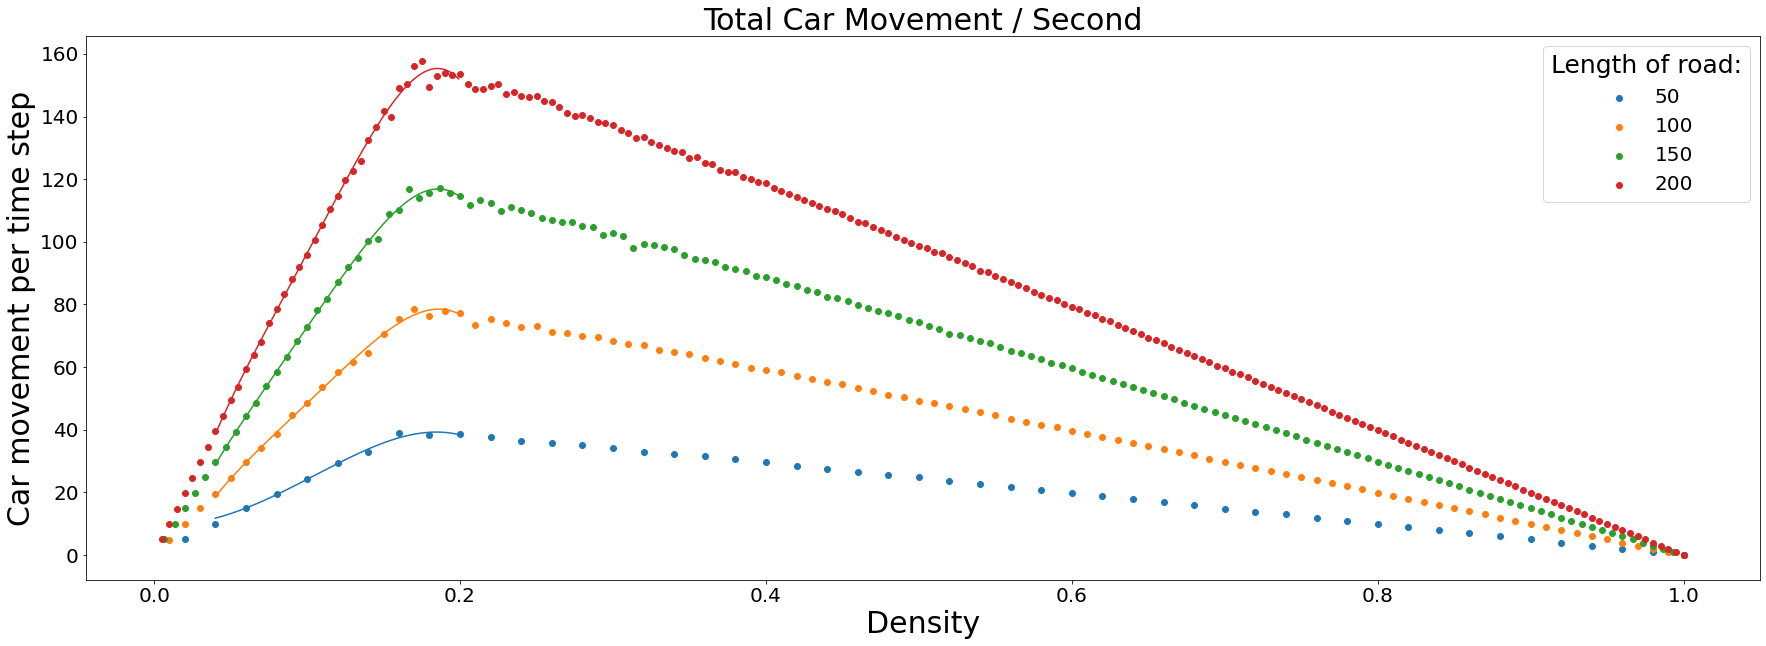

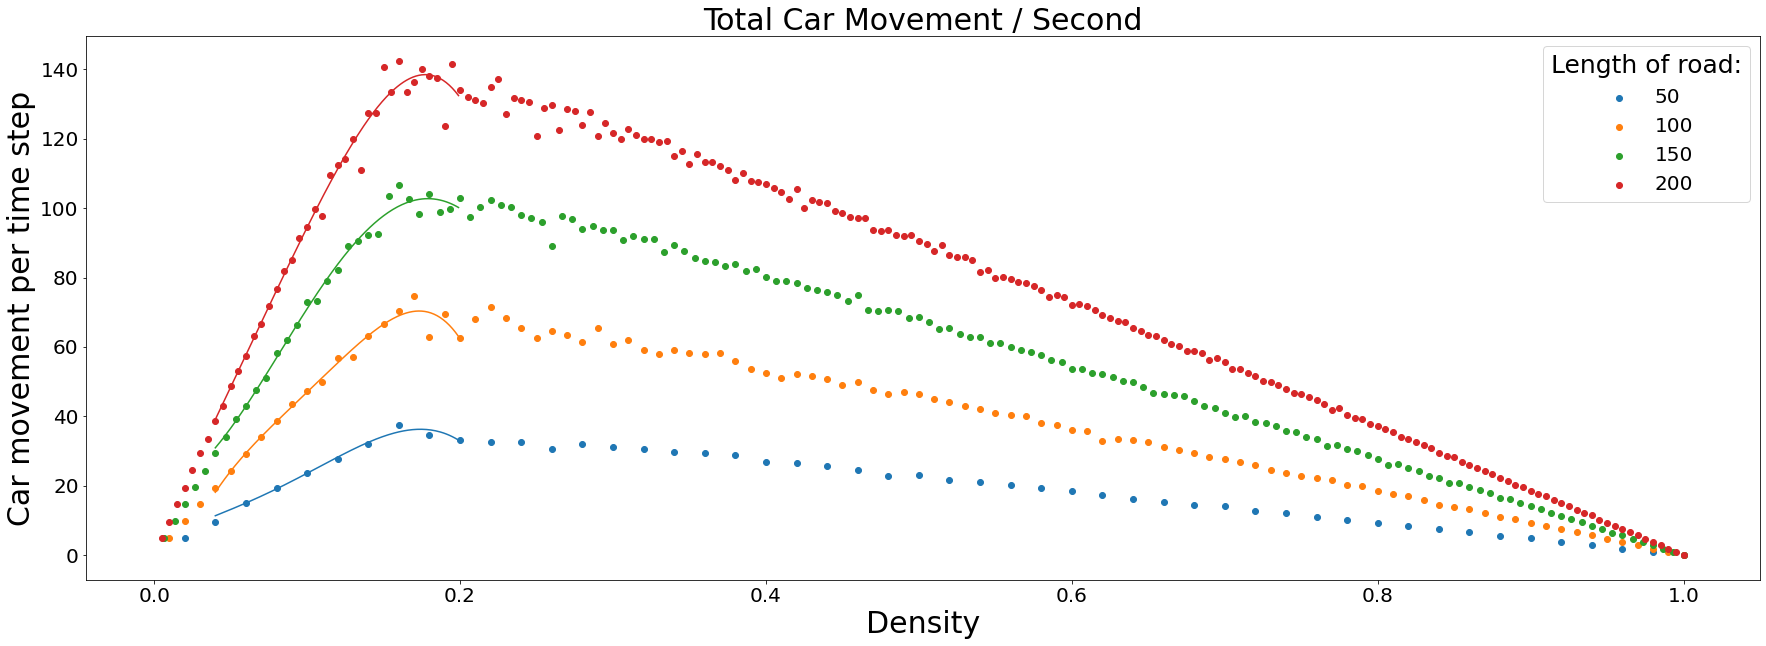

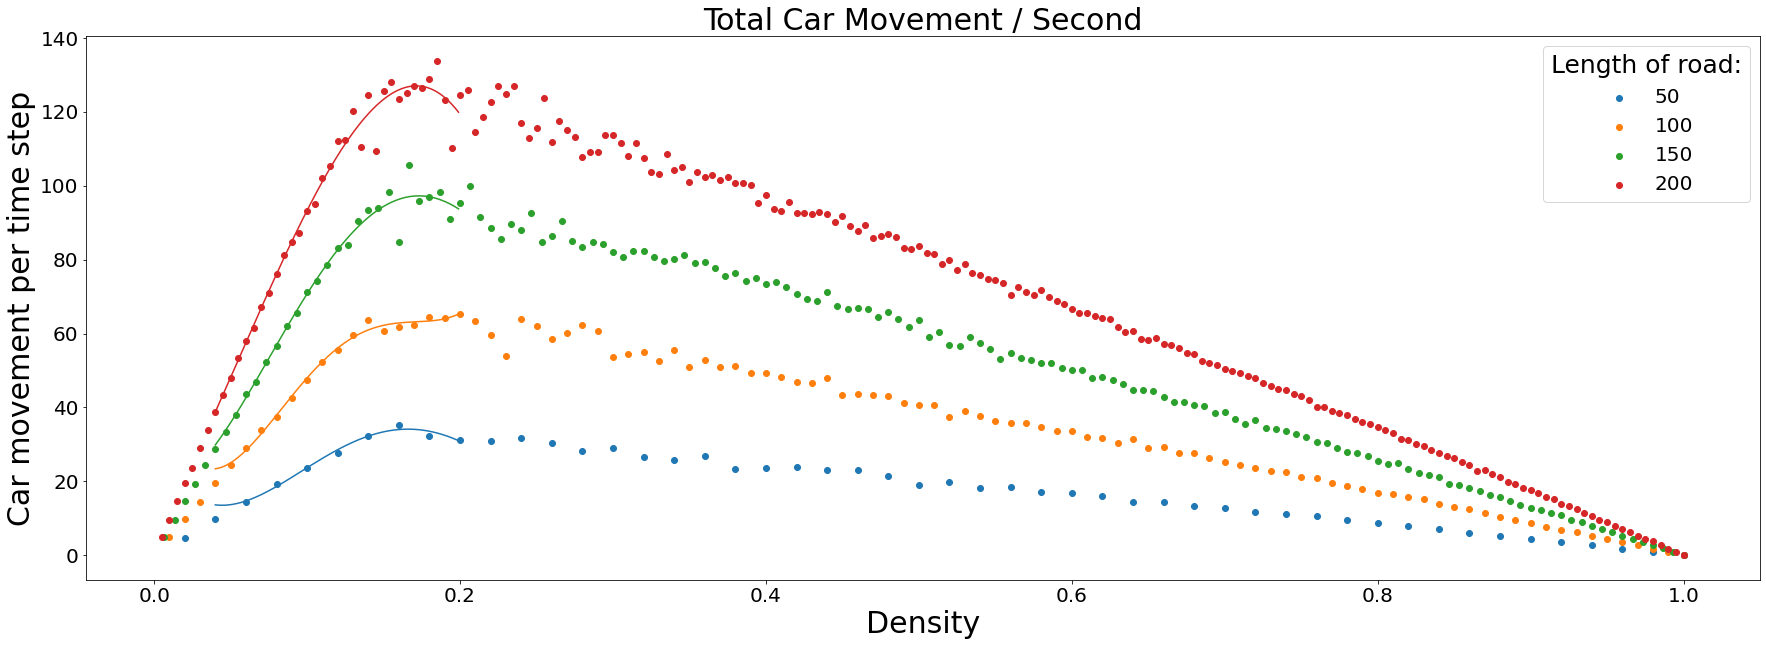

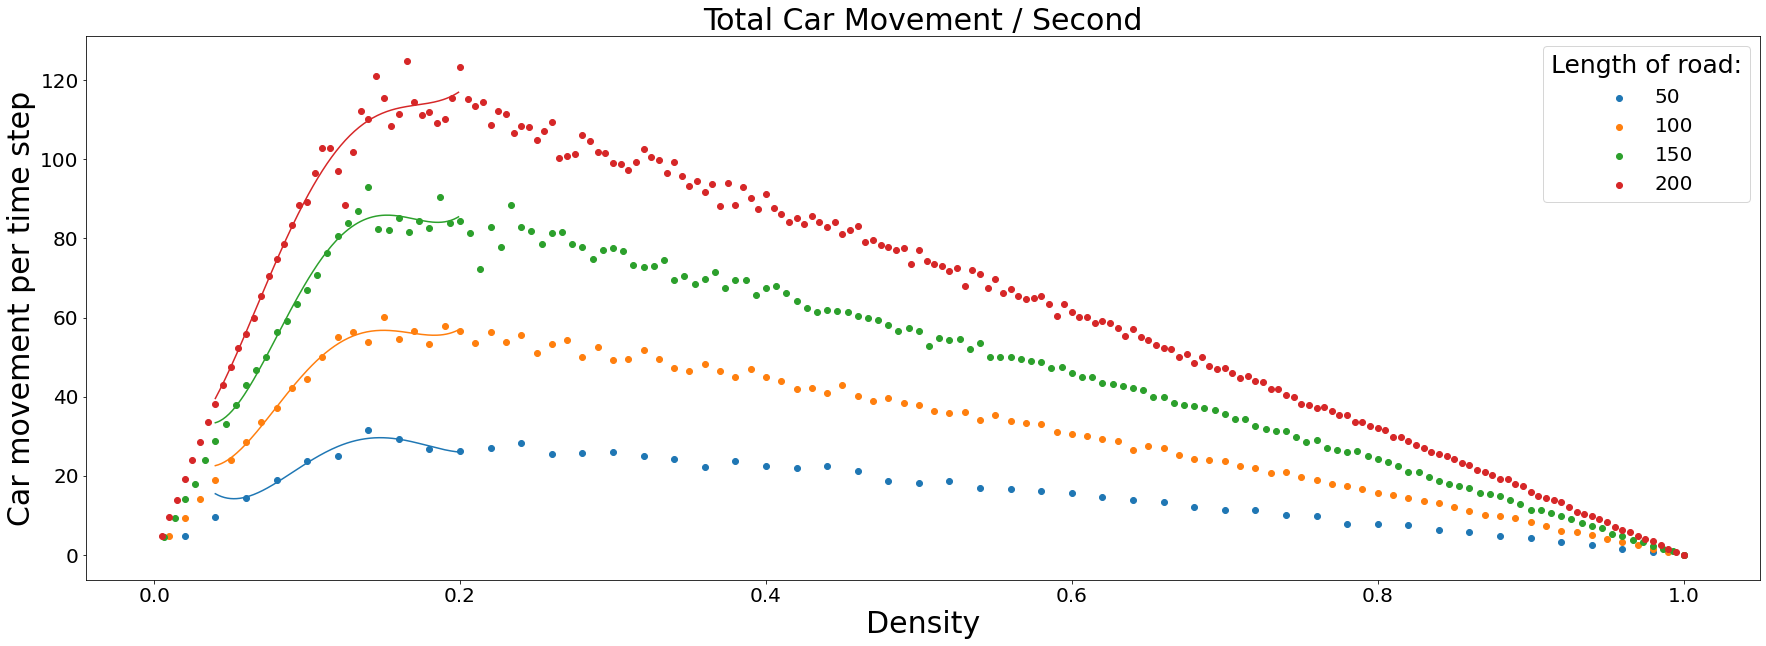

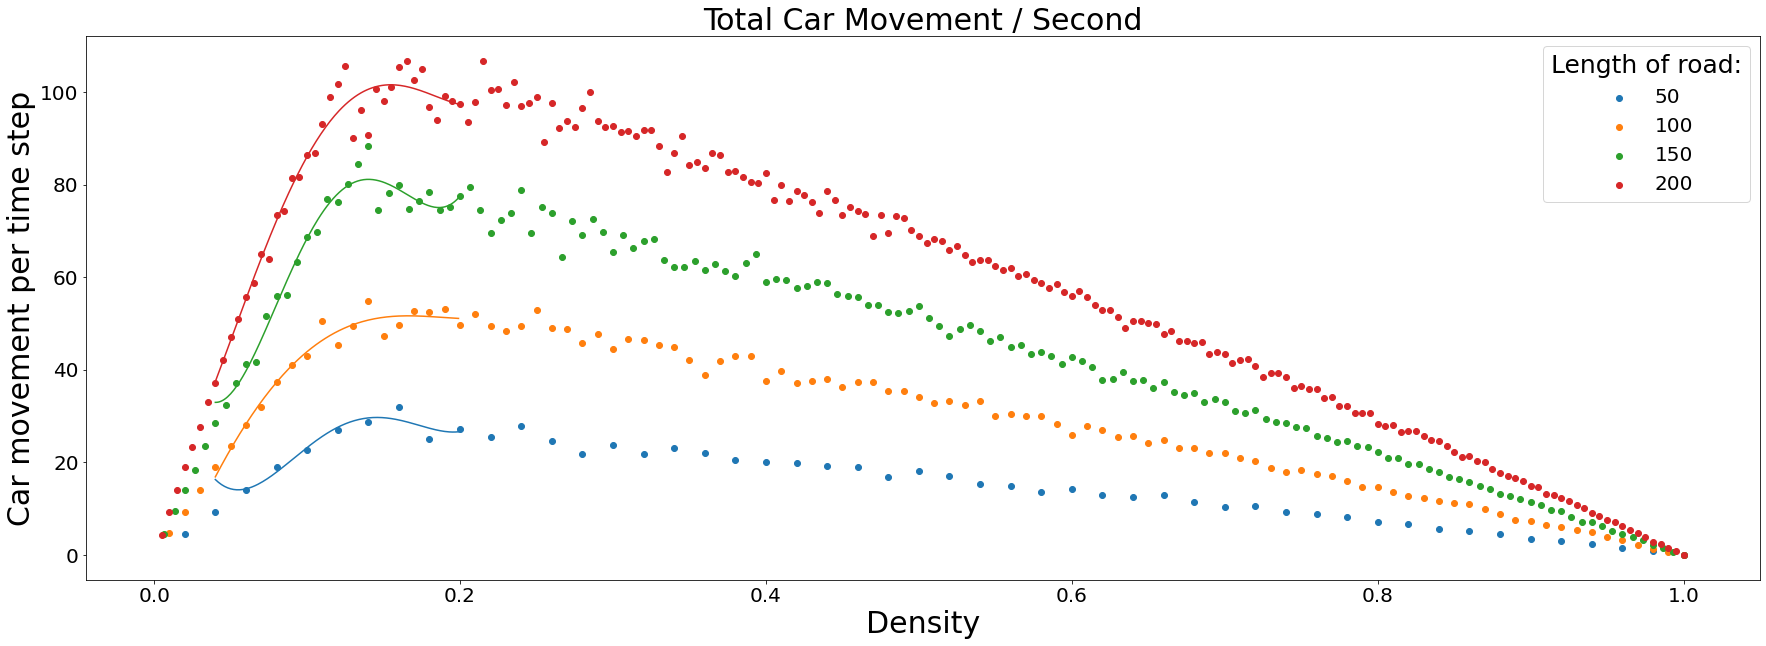

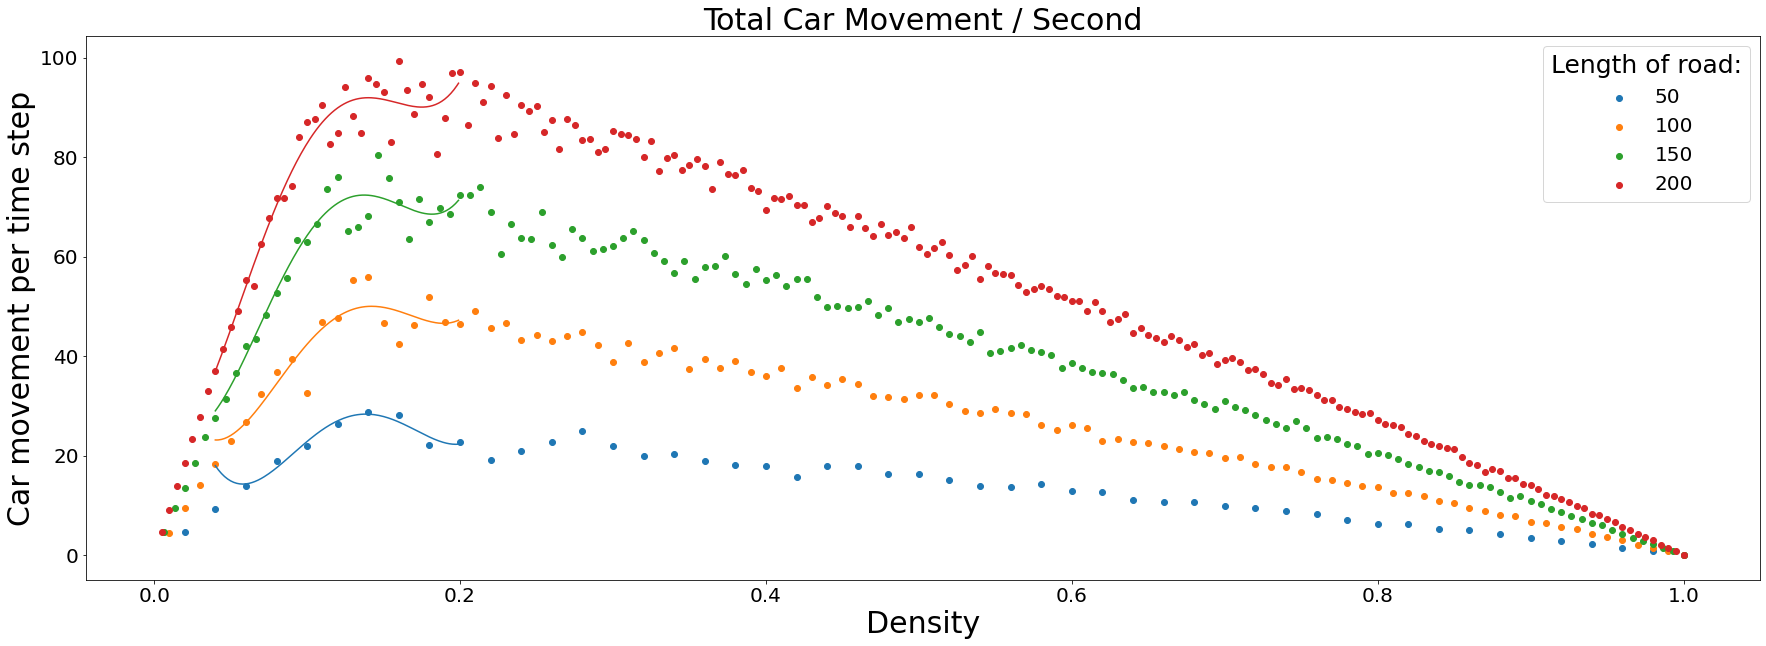

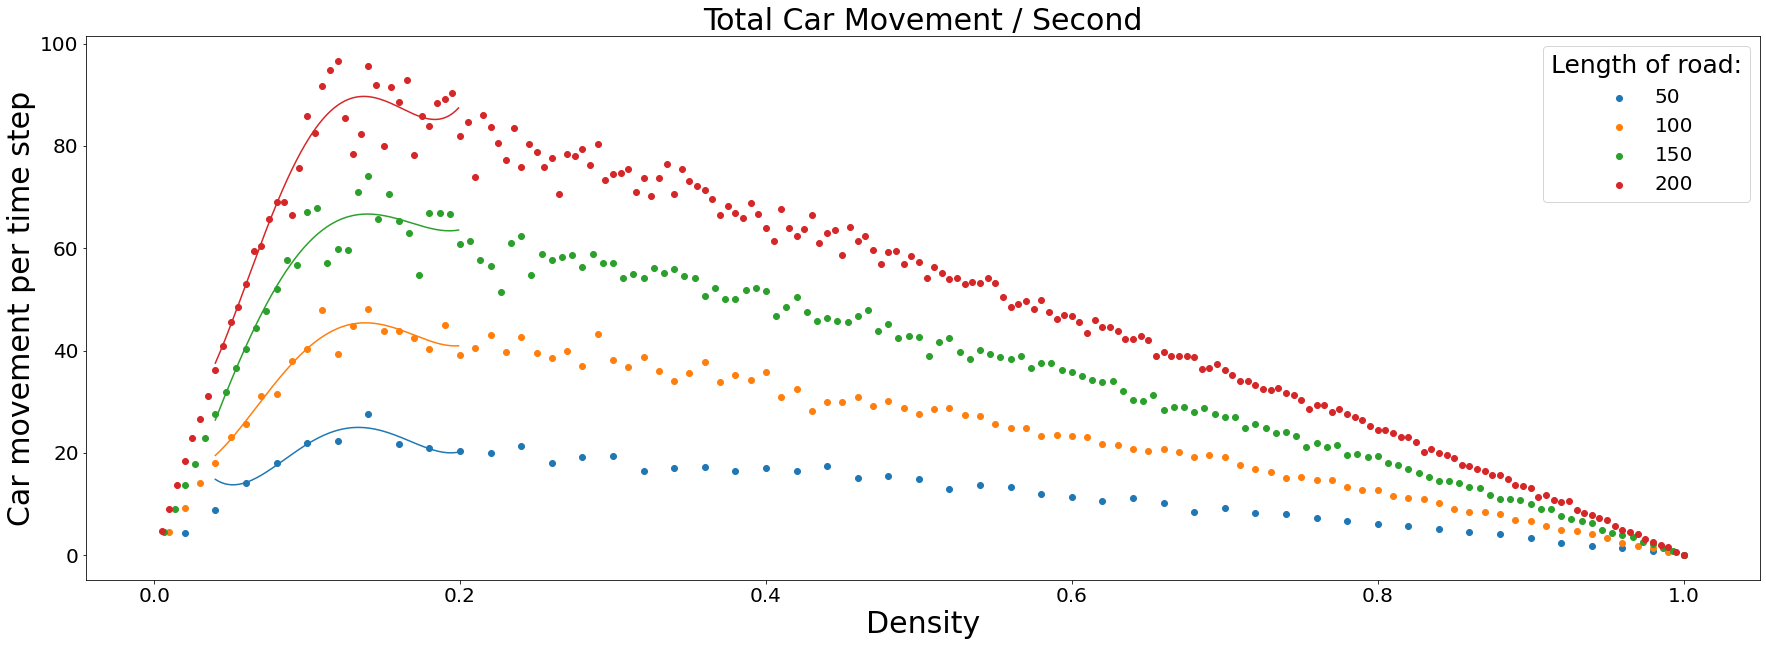

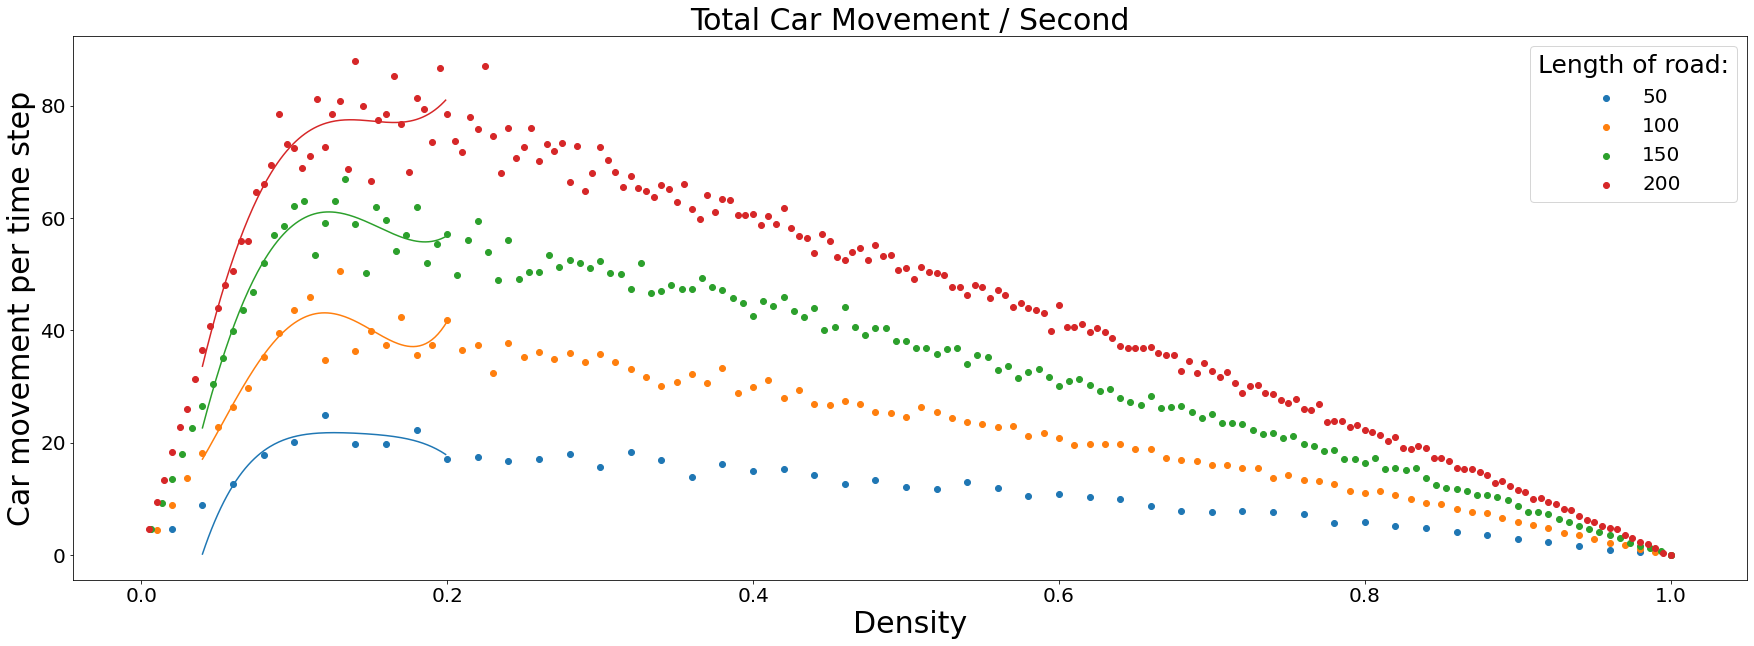

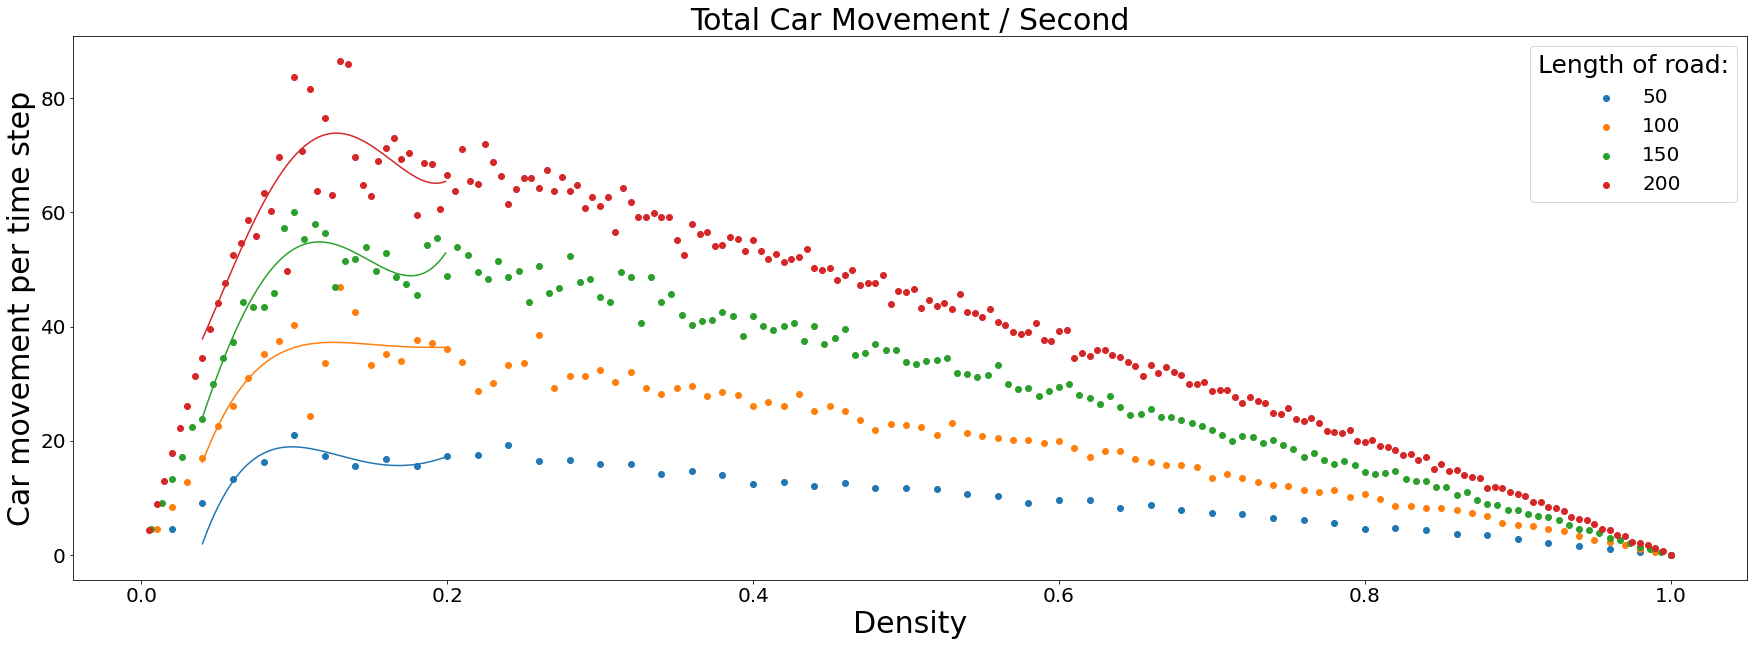

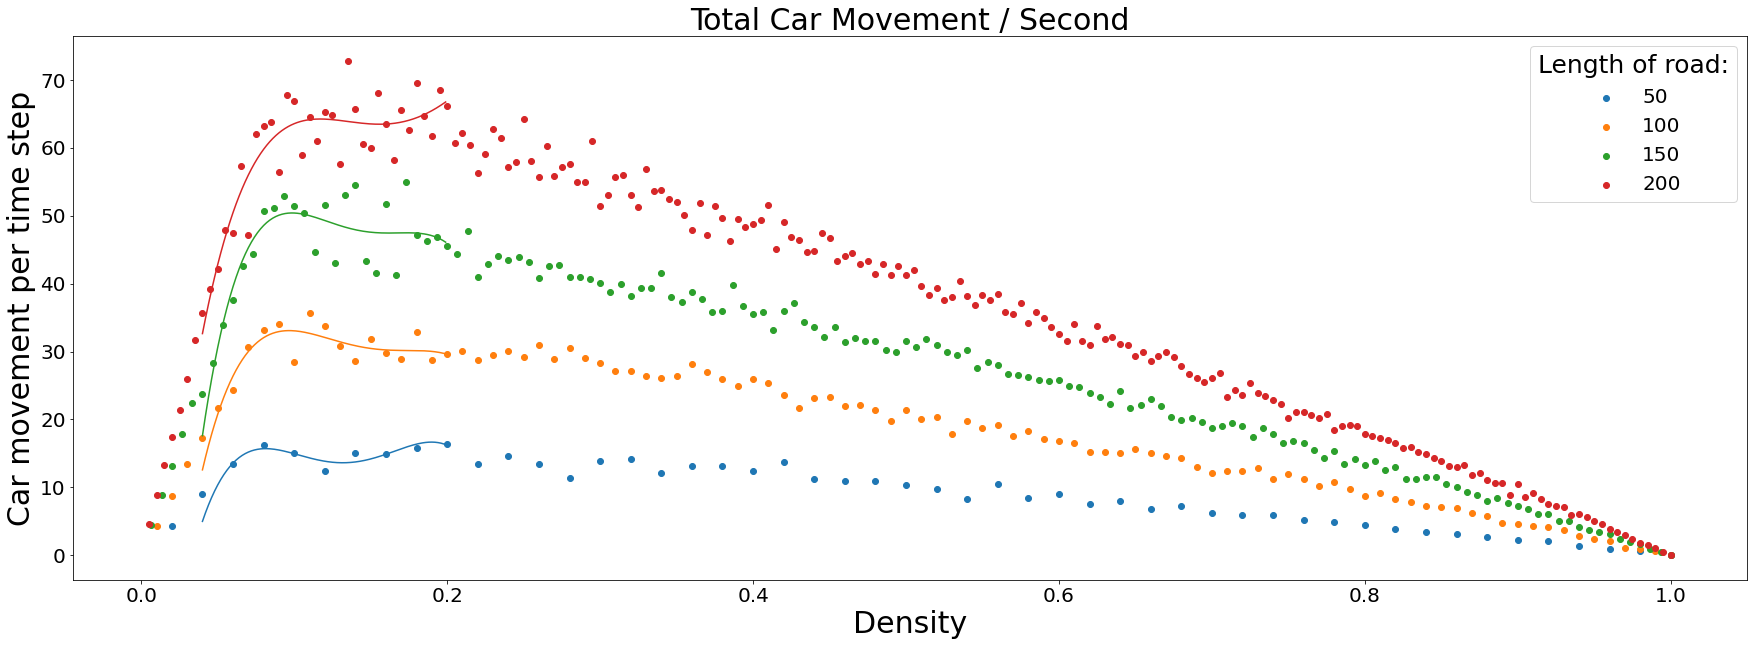

Maximum traffic volume / length of road: 0.333 ± 0.002
Density of cars at this maxmimum: 0.146 ± 0.048


In [ ]:
lengths = [50, 100, 150, 200]
probabilities = np.linspace(0,0.5,10)
for probability_slow_down in probabilities:
  [maximum_car_movements, maximum_densities] = flow_against_density(lengths, maximum_velocity, 
                                                                    probability_slow_down, True)

average_max_movement = np.average(maximum_car_movements)
error_max_movement = np.std(maximum_car_movements)
average_max_density = np.average(maximum_densities)
error_max_density = np.std(maximum_densities)

print("Maximum traffic volume / length of road: {:2.3f} \u00B1 {:2.3f}".format(
    average_max_movement, error_max_movement))
print("Density of cars at this maxmimum: {:2.3f} \u00B1 {:2.3f}".format(
    average_max_density, error_max_density))


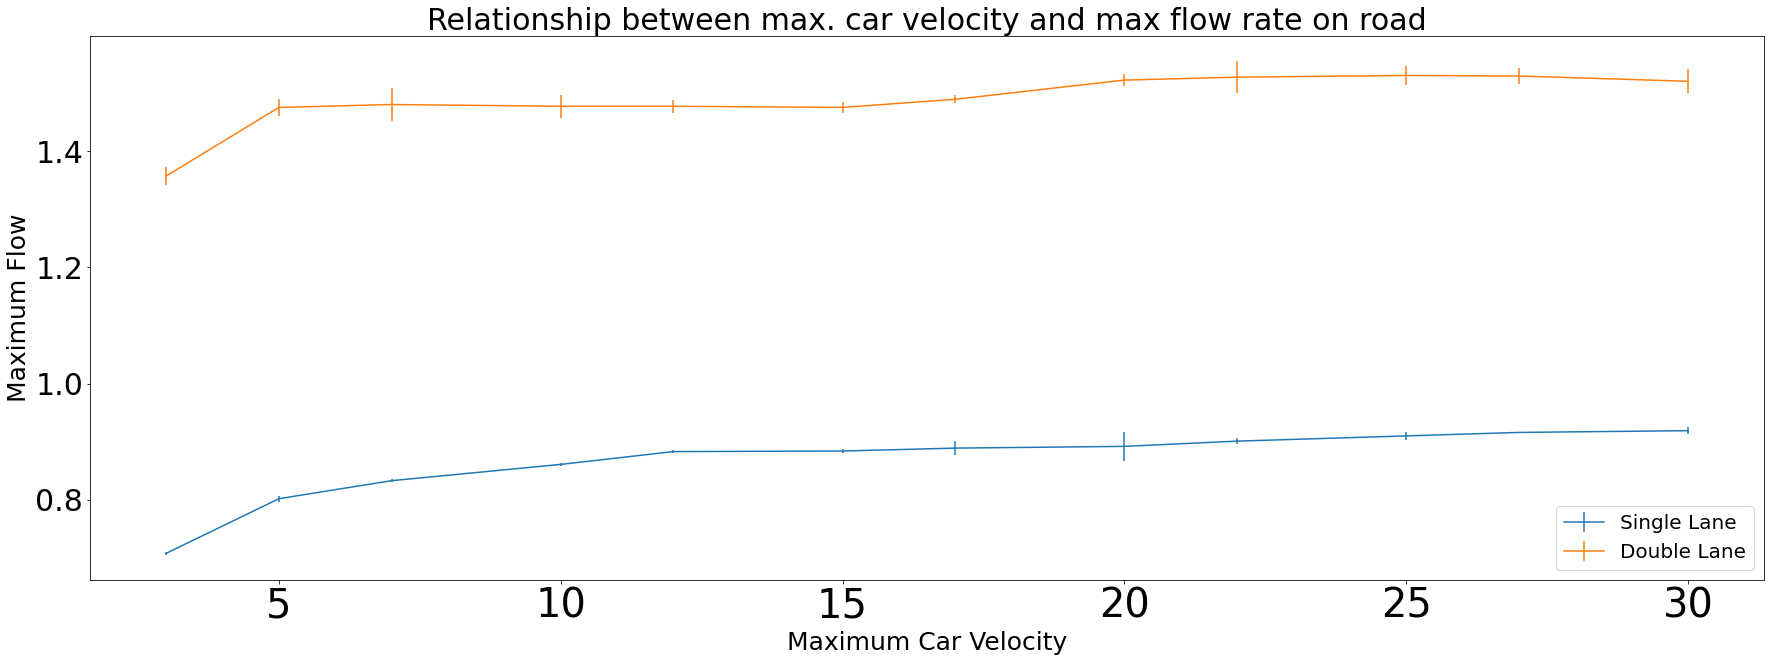

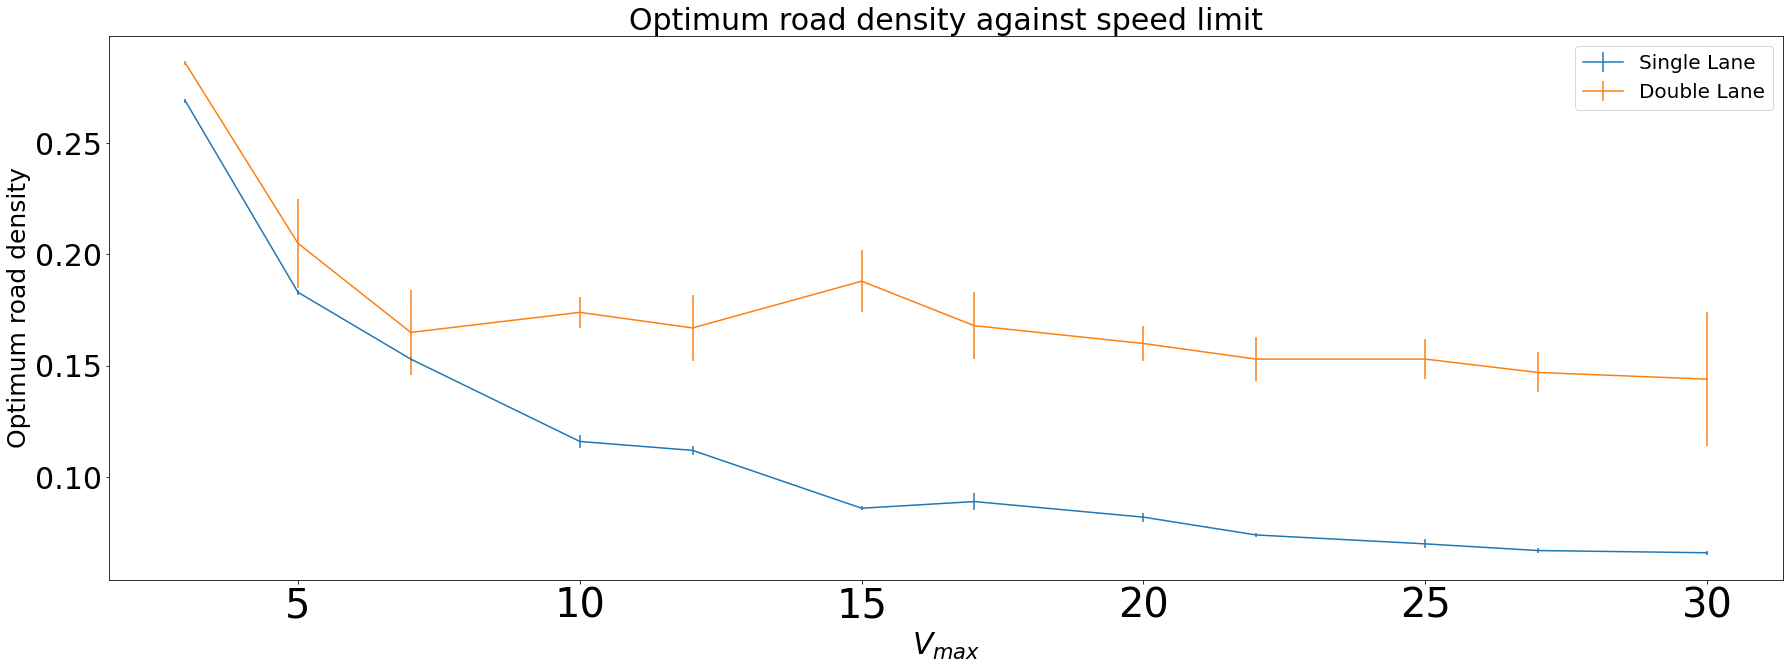

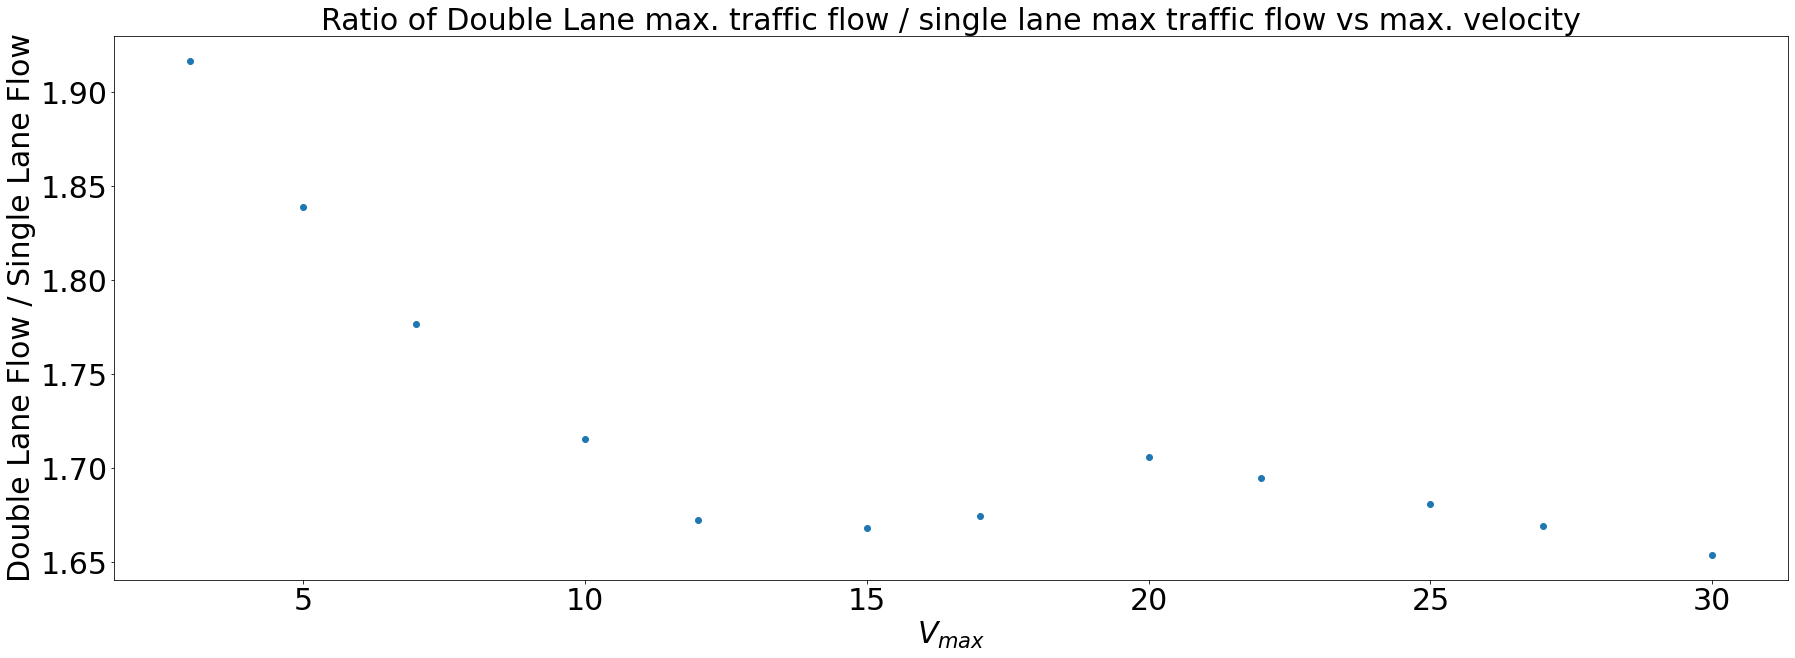

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

velocities = [3, 5, 7, 10, 12, 15, 17, 20, 22, 25, 27, 30]

#all below values found from using the above code cell and the single lane model previously created to take measurements of 
#maximum flow and density at this maximum flow for various velocities.

max_flow_single = np.array([0.708, 0.802, 0.833, 0.861, 0.883, 0.884, 0.889, 0.892, 0.901, 0.910, 0.916, 0.919])
max_flow_single_uncertainties = [0.003, 0.005, 0.003, 0.003, 0.003, 0.003, 0.012, 0.025, 0.005, 0.007, 0.0012, 0.006]

max_flow_double = np.array([1.357, 1.475, 1.480, 1.477, 1.477, 1.475, 1.489, 1.522, 1.527, 1.530, 1.529, 1.520])
max_flow_double_uncertainties = [0.015, 0.015, 0.028, 0.020, 0.011, 0.010, 0.007, 0.011, 0.028, 0.017, 0.014, 0.021]

max_density_single = [0.269, 0.183, 0.153, 0.116, 0.112, 0.086, 0.089, 0.082, 0.074, 0.07, 0.067, 0.066]
max_density_single_uncertainties = [0.001, 0.001, 0.001, 0.003, 0.002, 0.001, 0.004, 0.002, 0.001, 0.002, 0.001, 0.001]

max_density_double = [0.286, 0.205, 0.165, 0.174, 0.167, 0.188, 0.168, 0.16, 0.153, 0.153, 0.147, 0.144   ]
max_density_double_uncertainties = [0.001, 0.02, 0.019, 0.007, 0.015, 0.014, 0.015, 0.008, 0.01, 0.009, 0.009, 0.03]

ratio_double_flow_to_single_flow = (max_flow_double / max_flow_single)

plt.figure(figsize=(30,10))
plt.errorbar(velocities, max_flow_single, max_flow_single_uncertainties, label='Single Lane')
plt.errorbar(velocities, max_flow_double, max_flow_double_uncertainties, label='Double Lane')
plt.legend()
plt.title("Relationship between max. car velocity and max flow rate on road")
plt.ylabel("Maximum Flow")
plt.xlabel("Maximum Car Velocity")
plt.show()

plt.figure(figsize=(30,10))
plt.rc('legend', fontsize=20)
plt.errorbar(velocities, max_density_single, max_density_single_uncertainties, label='Single Lane')
plt.errorbar(velocities, max_density_double, max_density_double_uncertainties, label='Double Lane')
plt.legend()
plt.title("Optimum road density against speed limit")
plt.ylabel("Optimum road density")
plt.xlabel("$V_{max}$",{'fontsize':30})
plt.show()

plt.figure(figsize=(30,10))

plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)

plt.scatter(velocities, ratio_double_flow_to_single_flow)
plt.title("Ratio of Double Lane max. traffic flow / single lane max traffic flow vs max. velocity")
plt.ylabel("Double Lane Flow / Single Lane Flow")
plt.xlabel("$V_{max}$")
plt.show()

The below code was written to try to find optimum road 'speed limits' given a specific density of cars on the road. Essentially, the car flow increases rapidly but then is largely unaffected by making the maximum road velocity very high as cars never reach this speed (the bizarre looking zig zag graph shows how this correlation is quite weak aslong as the speed limit is above 5 or so). The later figure shows this more clearly where the flow levels off above some speed limit. 

This second graph was repeated for a road length of 400 as well as 100 to emphasise that this affect was not just because the road is too short for the cars to reach these higher speed limits. 

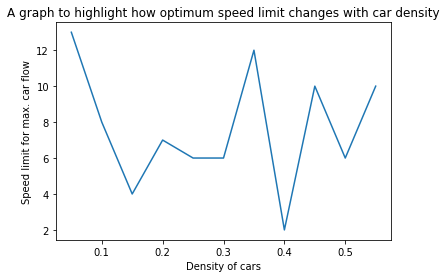

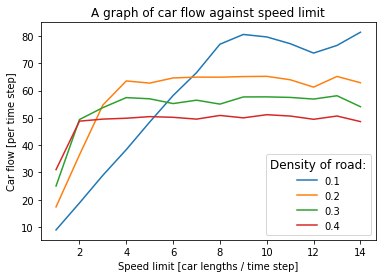

In [ ]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
#%matplotlib inline
repeats = 0
length_road = 100
road_densities = np.arange(0.05, 0.6, 0.05)
time = 200
probability_slow_down = 0.1

def create_road(length, cars, maximum_velocity):
    road = np.full(shape=length, fill_value=-1, dtype=np.int)
    counter = 0
    all_positions = np.array([])
    while counter < cars:
        position = random.randint(length)
        if position not in all_positions[:]:
            road[position] = maximum_velocity
            counter += 1
        all_positions = np.append(all_positions, position)
    return road

def space_infront(road, car_velocity, position): 
    if car_velocity == -1:
        return 0
    else:
        distance_counter = 0
        found_car = 0
        while found_car == 0:
            distance_counter += 1
            try:
                if road[position + distance_counter] >= 0:
                    found_car = 1
            except IndexError:
                if road[position + distance_counter - len(road)] >= 0:
                    found_car = 1

        return distance_counter
    
def acceleration_phase(road, maximum_velocity):
    for position, car_velocity in enumerate(road[:]):
        if -1 < car_velocity < maximum_velocity and space_infront(road, car_velocity, position) > (car_velocity + 1):
            road[position] = road[position] + 1
    return road

def slowing_phase(road):
    for position, car_velocity in enumerate(road[:]):
        if space_infront(road, car_velocity, position) <= car_velocity:
            road[position] = space_infront(road, car_velocity, position) - 1
    return road

def randomise_phase(road, probability_slow_down):
    for position, car_velocity in enumerate(road[:]):
        if car_velocity > 0:
            if np.random.uniform(0, 1) < probability_slow_down:
                road[position] = road[position] - 1
    return road

def moving_phase(road, length_road):
    new_road = np.full(shape=length_road, fill_value=-1, dtype=np.int) #First creates an empty road.
    new_road[0] = -1
    cars_moved = 0
    for position, car_velocity in enumerate(road[:]):
        try:
            if car_velocity >= 0:
              new_road[position + car_velocity] = road[position]
        except IndexError:
          new_road[position + car_velocity - len(road)] = car_velocity

    return new_road

def speed_limit_given_density(road_density, length_road, probability_slow_down, max_velocities):
    cars_per_second = []
    for maximum_velocity in max_velocities:
        cars = length_road * road_density
        t=0
        road = create_road(length_road, cars, maximum_velocity)
        total_car_distance = 0
        while t < time:
            #changing velocities
                accelerated_road = acceleration_phase(road, maximum_velocity)
                slowed_road = slowing_phase(accelerated_road)
                randomised_road = randomise_phase(slowed_road, probability_slow_down)
            #moving phase
                final_road = moving_phase(randomised_road, length_road)
            #updating step
                t += 1
                road = final_road
                for velocity in road:
                    if velocity > 0:
                        total_car_distance += velocity
        cars_per_second.append(total_car_distance/(time))
    fastest_flow = max(cars_per_second)
    speed_limit = cars_per_second.index(fastest_flow)
    
    return speed_limit
    
max_velocities = np.arange(1, 15, 1)

speed_limits = np.array([])
mean_speed_limits = np.array([])
speed_limit_uncertainty = np.array([])
for road_density in road_densities:
    speed_limits = np.zeros(0)
    repeat = 0
    while repeat <= repeats:
        speed_limit = speed_limit_given_density(
            road_density, length_road, probability_slow_down, max_velocities)
        speed_limits = np.append(speed_limits, speed_limit)
        repeat += 1
    mean_speed_limits = np.append(mean_speed_limits, np.average(speed_limits))
    speed_limit_uncertainty = np.append(speed_limit_uncertainty, np.std(speed_limits))

plt.figure()
plt.errorbar(road_densities, mean_speed_limits, yerr=speed_limit_uncertainty)
plt.title("A graph to highlight how optimum speed limit changes with car density")
plt.ylabel("Speed limit for max. car flow")
plt.xlabel("Density of cars")
plt.show()

road_densities = [0.1, 0.2, 0.3, 0.4]
plt.figure()
for road_density in road_densities:
    cars_per_second = []
    for maximum_velocity in max_velocities:
        cars = length_road * road_density
        t=0
        road = create_road(length_road, cars, maximum_velocity)
        total_car_distance = 0
        while t < time:
                #changing velocities
                accelerated_road = acceleration_phase(road, maximum_velocity)
                slowed_road = slowing_phase(accelerated_road)
                randomised_road = randomise_phase(slowed_road, probability_slow_down)
                #moving phase
                final_road = moving_phase(randomised_road, length_road)
                #updating step
                t += 1
                road = final_road
                for velocity in road:
                    if velocity > 0:
                        total_car_distance += velocity
        cars_per_second.append(total_car_distance/(time))
    plt.plot(max_velocities, cars_per_second, label=road_density)

plt.title("A graph of car flow against speed limit")
plt.ylabel("Car flow [per time step]")
plt.xlabel("Speed limit [car lengths / time step]")
plt.legend(title="Density of road:", fontsize=10, title_fontsize=12)
plt.show()

Here, the number of sharp breaks made by cars was looked at. A sharp break occcured when a car had to break 4 or more velocity units in one time step. This was graphed against speed limit so it could be contrasted with the above graphs. Together these two graphs could be used to determine the best (highest flow but also safest) speed limits for different road densities. 

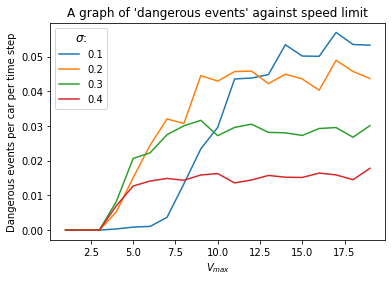

In [ ]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
#%matplotlib inline
length_road = 500
time = 300
probability_slow_down = 0.1


def create_road(length, cars, maximum_velocity):
    road = np.full(shape=length, fill_value=-1, dtype=np.int)
    counter = 0
    all_positions = np.array([])
    while counter < cars:
        position = random.randint(length)
        if position not in all_positions[:]:
            road[position] = maximum_velocity
            counter += 1
        all_positions = np.append(all_positions, position)
    return road

def space_infront(road, car_velocity, position): 
    if car_velocity == -1:
        return 0
    else:
        distance_counter = 0
        found_car = 0
        while found_car == 0:
            distance_counter += 1
            try:
                if road[position + distance_counter] >= 0:
                    found_car = 1
            except IndexError:
                if road[position + distance_counter - len(road)] >= 0:
                    found_car = 1

        return distance_counter
    
def acceleration_phase(road, maximum_velocity):
    for position, car_velocity in enumerate(road[:]):
        if -1 < car_velocity < maximum_velocity and space_infront(road, car_velocity, position) > (car_velocity + 1):
            road[position] = road[position] + 1
    return road

def slowing_phase(road):
    heavy_breaks = 0
    for position, car_velocity in enumerate(road[:]):
        if space_infront(road, car_velocity, position) <= car_velocity:
            road[position] = space_infront(road, car_velocity, position) - 1
        if space_infront(road, car_velocity, position) < (car_velocity - 2):
            heavy_breaks += 1
    return road, heavy_breaks

def randomise_phase(road, probability_slow_down):
    for position, car_velocity in enumerate(road[:]):
        if car_velocity > 0:
            if np.random.uniform(0, 1) < probability_slow_down:
                road[position] = road[position] - 1
    return road

def moving_phase(road, length_road):
    new_road = np.full(shape=length_road, fill_value=-1, dtype=np.int) #First creates an empty road.
    new_road[0] = -1
    cars_moved = 0
    for position, car_velocity in enumerate(road[:]):
        try:
            if car_velocity >= 0:
              new_road[position + car_velocity] = road[position]
        except IndexError:
          new_road[position + car_velocity - len(road)] = car_velocity

    return new_road

max_velocities = np.arange(1, 20, 1)
road_densities = [0.1, 0.2, 0.3, 0.4]
plt.figure()
for road_density in road_densities:
    cars_per_second = []
    percentage_heavy_breaks = []
    for maximum_velocity in max_velocities:
        cars = length_road * road_density
        t=0
        road = create_road(length_road, cars, maximum_velocity)
        total_car_distance = 0
        total_heavy_breaks = 0
        while t < time:
                #changing velocities
                accelerated_road = acceleration_phase(road, maximum_velocity)
                [slowed_road, heavy_breaks] = slowing_phase(accelerated_road)
                randomised_road = randomise_phase(slowed_road, probability_slow_down)
                #moving phase
                final_road = moving_phase(randomised_road, length_road)
                #updating step
                t += 1
                road = final_road
                total_heavy_breaks += heavy_breaks
                for velocity in road:
                    if velocity > 0:
                        total_car_distance += velocity
        cars_per_second.append(total_car_distance/(time))
        percentage_heavy_breaks.append(total_heavy_breaks/(cars * time))
    plt.plot(max_velocities, percentage_heavy_breaks, label=road_density)

plt.title("A graph of 'dangerous events' against speed limit")
plt.ylabel("Dangerous events per car per time step")
plt.xlabel("$V_{max}$")
plt.legend(title="$\sigma$:", fontsize=10, title_fontsize=12)
plt.show()

## Density plots

In [ ]:
starting_densities = np.linspace(0,0.4,15)

In [ ]:
t = 0

all_roads = np.array([]) #This array is used to store all of the roads (after every movement)
empty_road = np.empty(length)
empty_road.fill(-1)
all_roads = np.append(all_roads, empty_road) #starts with an empty road (to all vstack)
final_density_double = []
for density in starting_densities:
  cars = density*length
  road = create_double(length, cars)
  densities = []
  t=0
  while t < time:

  #changing velocities
      changed_road = lane_change(road)
      accelerated_road = acceleration_double(changed_road, maximum_velocity)
      slowed_road = slowing_double(accelerated_road)
      randomised_road = randomise_double(slowed_road, probability_slow_down)
      all_roads = np.vstack((all_roads, randomised_road)).astype(int)

      #print("Step:", t)
      #print("First lane cars:", sum(np.bincount(changed_road[0]+1)[1:]))
      #print("Second lane cars:", sum(np.bincount(changed_road[1]+1)[1:]))

  #moving phase
      final_road = moving_double(randomised_road, length, loop=False)

  #updating step
      t += 1
      total_cars = sum(np.bincount(final_road[0]+1)[1:])+sum(np.bincount(final_road[1]+1)[1:])
      densities.append(total_cars/(2*length))
  final_density_double.append(densities)


NameError: ignored

In [ ]:
t = 0
time = 300
length = 300
maximum_velocity = 10
all_roads = np.array([]) #This array is used to store all of the roads (after every movement)
empty_road = np.empty(length)
empty_road.fill(-1)
all_roads = np.append(all_roads, empty_road) #starts with an empty road (to all vstack)
final_density_2 = []
for density in starting_densities:
  cars = density*length
  road = create_road(length, cars)
  densities = [density]
  t=0
  while t < time:

  #changing velocities
        accelerated_road = acceleration_phase(road, maximum_velocity)
        slowed_road = slowing_phase(accelerated_road)
        randomised_road = randomise_phase(slowed_road, probability_slow_down)
    #moving phase
        final_road = moving_phase(randomised_road, length, loop=False)
    #updating step
        t += 1
        road = final_road
        total_cars = sum(np.bincount(final_road+1)[1:])
        densities.append(total_cars/(length))
  final_density_2.append(densities)


In [ ]:
t = 0
time = 300
length = 300
velocities = np.arange(20)+1


all_roads = np.array([]) #This array is used to store all of the roads (after every movement)
empty_road = np.empty(length)
empty_road.fill(-1)
all_roads = np.append(all_roads, empty_road) #starts with an empty road (to all vstack)
final_density= []
density_vs_velocity = []

for maximum_velocity in velocities:
  final_density = []
  density_sum=0
  for density in starting_densities:
    cars = density*length
    road = create_road(length, cars)
    densities = [density]
    t=0
    while t < time:

    #changing velocities
          accelerated_road = acceleration_phase(road, maximum_velocity)
          slowed_road = slowing_phase(accelerated_road)
          randomised_road = randomise_phase(slowed_road, probability_slow_down)
      #moving phase
          final_road = moving_phase(randomised_road, length, loop=False)
      #updating step
          t += 1
          road = final_road
          total_cars = sum(np.bincount(final_road+1)[1:])
          densities.append(total_cars/(length))
    final_density.append(densities)

  for i in range(len(starting_densities)):
    density_sum += final_density[i][-1]

  density_vs_velocity.append(density_sum/len(starting_densities))
    


In [ ]:
def func(x, a, b, c):
  return a/(x+b) + c

def func_2(x, a, b, c):
  return a*np.exp(-b*x) + c

In [ ]:
popt, pcov = curve_fit(func, velocities, density_vs_velocity)
popt_2, pcov_2 = curve_fit(func_2, velocities, density_vs_velocity)

In [ ]:
x_data = np.linspace(1,20,500)

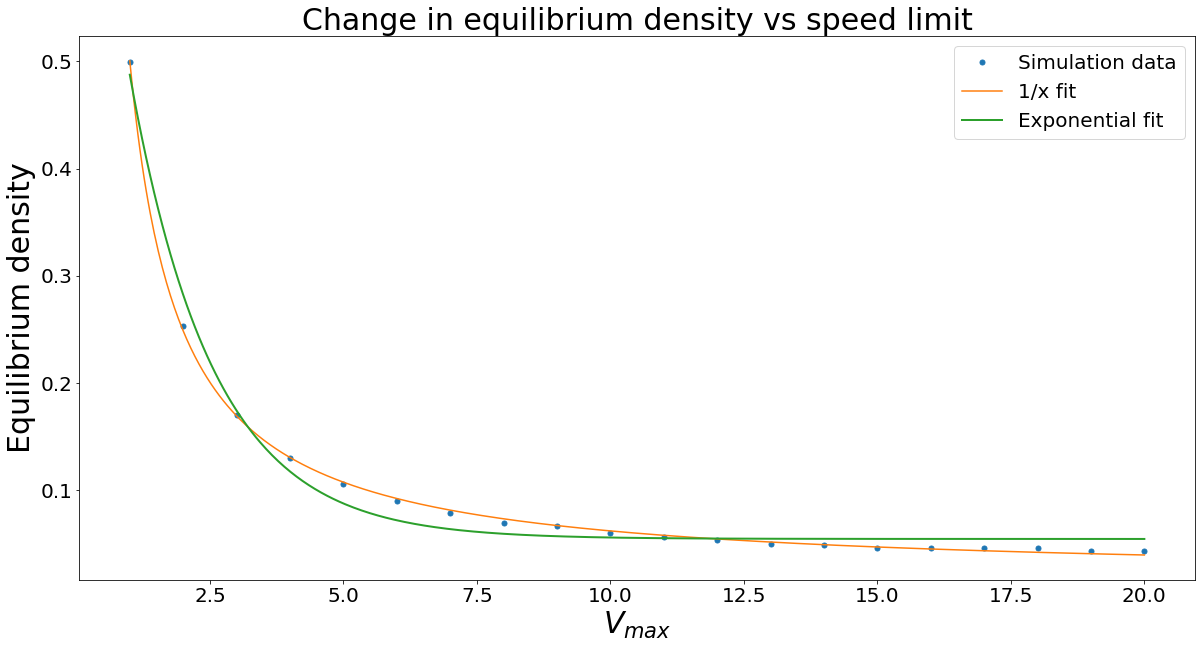

In [ ]:
plt.figure(figsize=(20,10))
plt.rc('legend', fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title('Change in equilibrium density vs speed limit', {'fontsize':30})
plt.xlabel('$V_{max}$', {'fontsize':30})
plt.ylabel('Equilibrium density', {'fontsize':30})
plt.plot(velocities, density_vs_velocity, '.', label='Simulation data', markersize=10)
plt.plot(x_data, func(x_data, *popt), label='1/x fit')
plt.plot(x_data, func_2(x_data, *popt_2),'-', label='Exponential fit', linewidth=2)
plt.legend()

Text(0, 0.5, 'Density')

<Figure size 432x288 with 0 Axes>

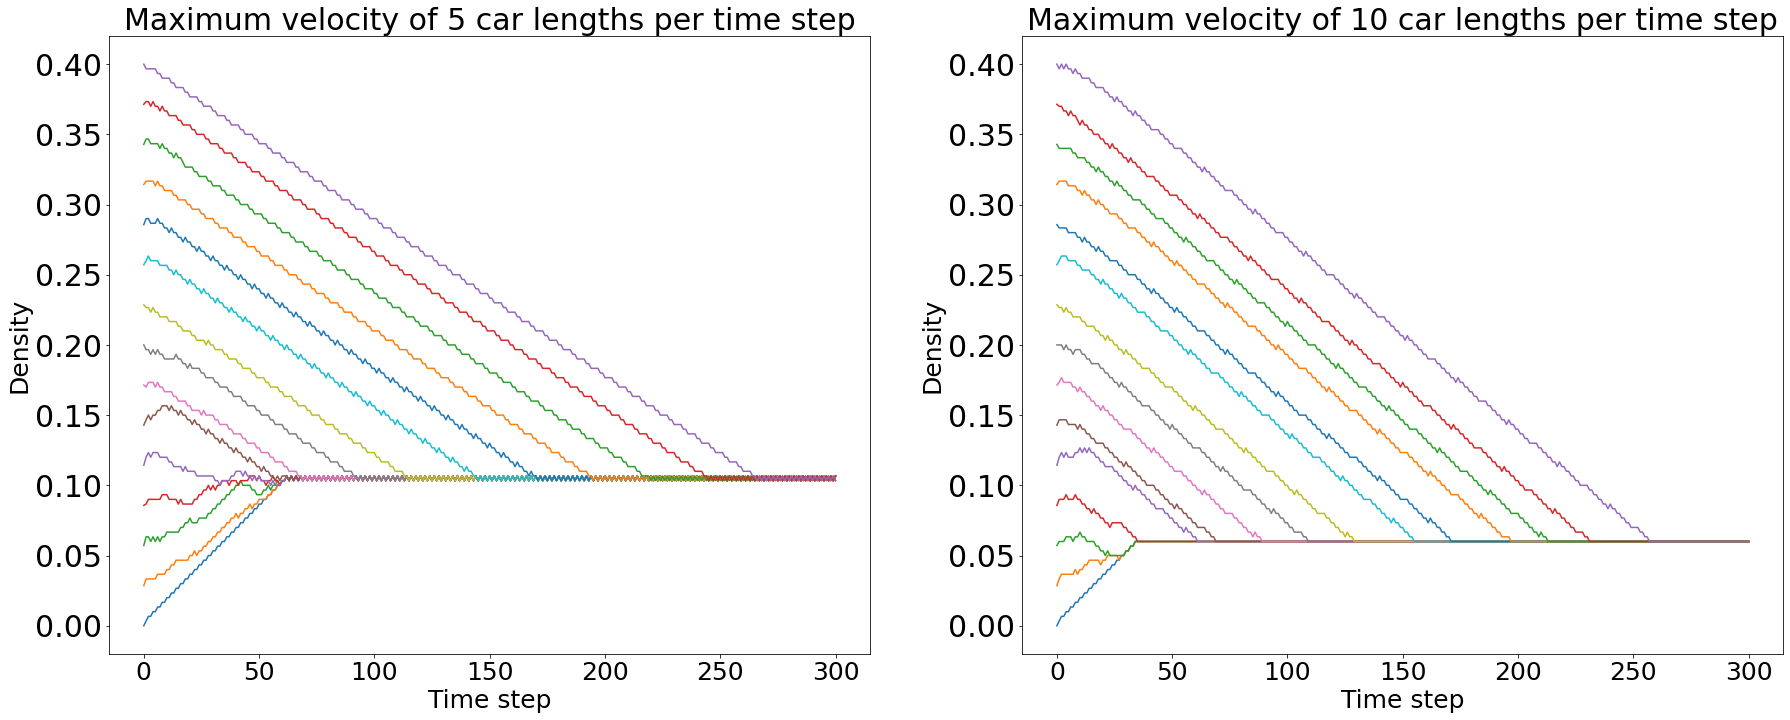

In [ ]:
fig = plt.figure()
plt.figure(figsize=(30,25))
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)

plt.subplot(2, 2, 1)
plt.title('Maximum velocity of 5 car lengths per time step')
for den in final_density_1:
  plt.plot(np.linspace(0,time,time+1), den)

plt.xlabel('Time step')
plt.ylabel("Density")
plt.subplot(2, 2, 2)
plt.title('Maximum velocity of 10 car lengths per time step')
for den in final_density_2:
  plt.plot(np.linspace(0,time,time+1), den)

plt.xlabel('Time step')
plt.ylabel("Density")



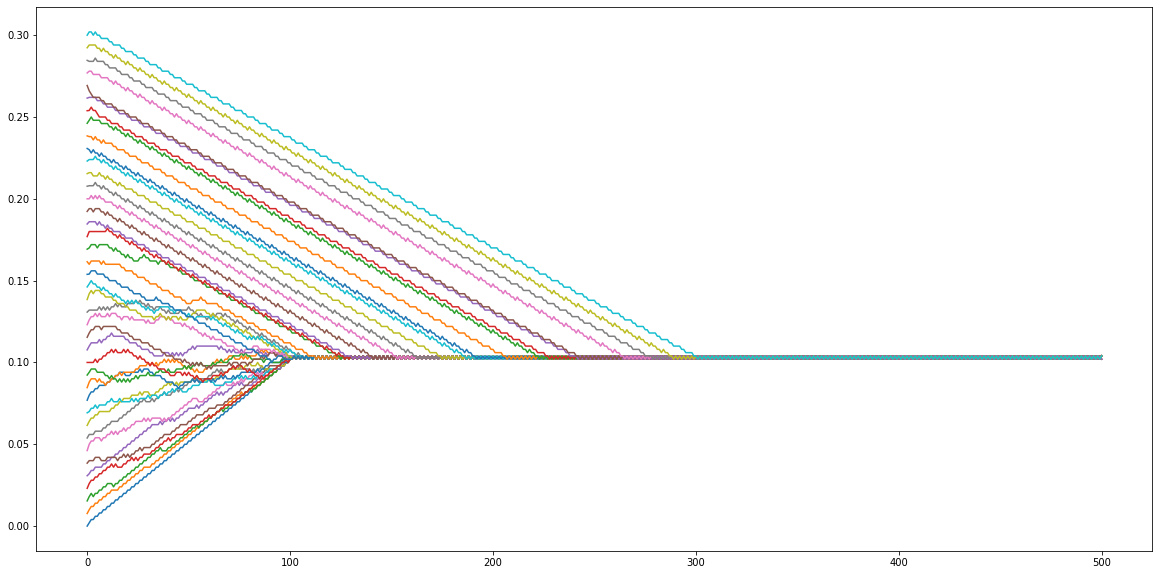

In [ ]:
plt.figure(figsize=(20,10))
for den in final_density:
  plt.plot(np.linspace(0,time,time+1), den)

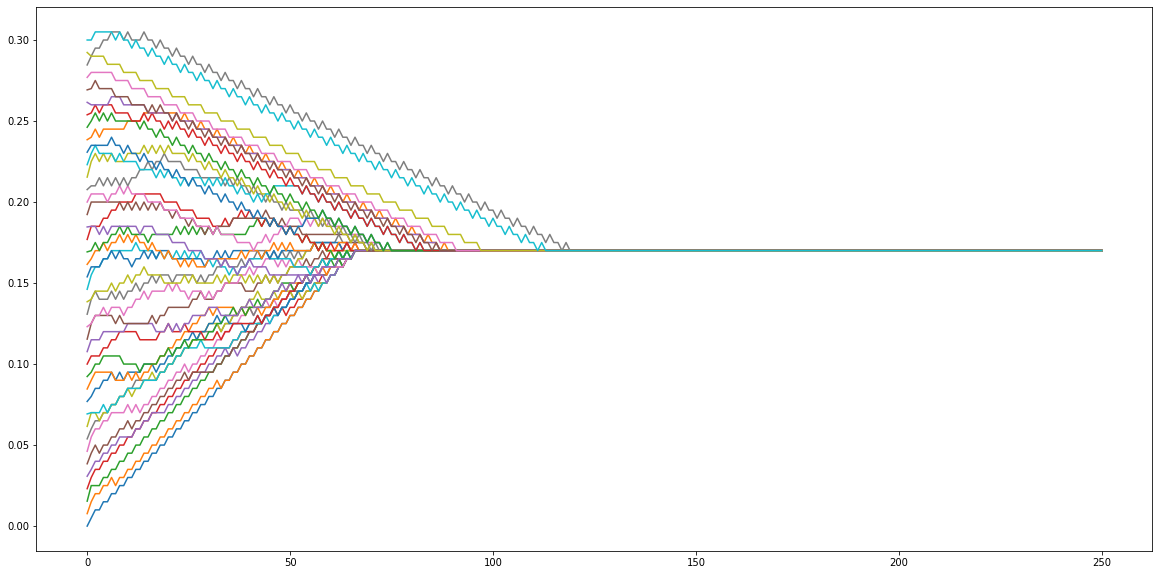

In [ ]:
plt.figure(figsize=(20,10))
for den in final_density:
  plt.plot(np.linspace(0,time,time+1), den)

In [ ]:
final_density[0][-1]

0.104

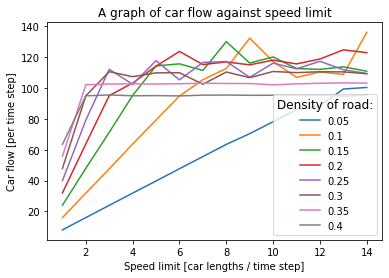

In [ ]:
road_densities = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
max_velocities = np.arange(1, 15, 1)
plt.figure()
for road_density in road_densities:
    cars_per_second = []
    for maximum_velocity in max_velocities:
        cars = length * road_density
        t=0
        road = create_double(length, cars)
        total_car_distance = 0
        while t < time:
                #changing velocities
                changed_road = lane_change(road)
                accelerated_road = acceleration_double(changed_road, maximum_velocity)
                slowed_road = slowing_double(accelerated_road)
                randomised_road = randomise_double(slowed_road, probability_slow_down)
                all_roads = np.vstack((all_roads, randomised_road)).astype(int)

                #print("Step:", t)
                #print("First lane cars:", sum(np.bincount(changed_road[0]+1)[1:]))
                #print("Second lane cars:", sum(np.bincount(changed_road[1]+1)[1:]))

            #moving phase
                final_road = moving_double(randomised_road, length, loop=True)
                #updating step
                t += 1
                road = final_road
                for lane in road:
                  for velocity in lane:
                      if velocity > 0:
                          total_car_distance += velocity
        cars_per_second.append(total_car_distance/(time))
    plt.plot(max_velocities, cars_per_second, label=road_density)

plt.title("A graph of car flow against speed limit")
plt.ylabel("Car flow [per time step]")
plt.xlabel("Speed limit [car lengths / time step]")
plt.legend(title="Density of road:", fontsize=10, title_fontsize=12)
plt.show()

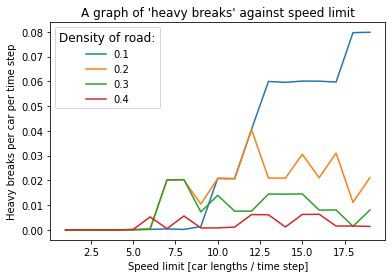

In [ ]:
max_velocities = np.arange(1, 20, 1)
road_densities = [0.1, 0.2, 0.3, 0.4]
plt.figure()

def slowing_phase(road):
    heavy_breaks = 0
    for position, car_velocity in enumerate(road[:]):
        if space_infront(road, car_velocity, position) <= car_velocity:
            road[position] = space_infront(road, car_velocity, position) - 1
        if space_infront(road, car_velocity, position) < (car_velocity - 3):
            heavy_breaks += 1
    return road, heavy_breaks

for road_density in road_densities:
    cars_per_second = []
    percentage_heavy_breaks = []
    for maximum_velocity in max_velocities:
        cars = length * road_density
        t=0
        road = create_road(length, cars)
        total_car_distance = 0
        total_heavy_breaks = 0
        while t < time:
                #changing velocities
                accelerated_road = acceleration_phase(road, maximum_velocity)
                [slowed_road, heavy_breaks] = slowing_phase(accelerated_road)
                randomised_road = randomise_phase(slowed_road, probability_slow_down)
                #moving phase
                final_road = moving_phase(randomised_road, length)
                #updating step
                t += 1
                road = final_road
                total_heavy_breaks += heavy_breaks
                for velocity in road:
                    if velocity > 0:
                        total_car_distance += velocity
        cars_per_second.append(total_car_distance/(time))
        percentage_heavy_breaks.append(total_heavy_breaks/(cars * time))
    plt.plot(max_velocities, percentage_heavy_breaks, label=road_density)

plt.title("A graph of 'heavy breaks' against speed limit")
plt.ylabel("Heavy breaks per car per time step")
plt.xlabel("Speed limit [car lengths / time step]")
plt.legend(title="Density of road:", fontsize=10, title_fontsize=12)
plt.show()

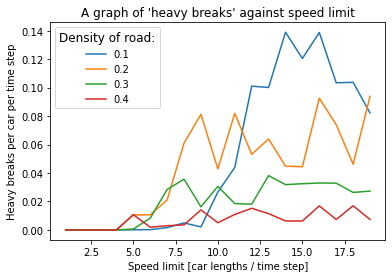

In [ ]:
max_velocities = np.arange(1, 20, 1)
road_densities = [0.1, 0.2, 0.3, 0.4]
plt.figure()

def slowing_double(road):
    road_new = np.full(shape=[2,length], fill_value=-1, dtype=np.int)
    heavy_breaks_tot = 0
    for lane in range(2):
      [road_new[lane], heavy_breaks] = slowing_phase(road[lane])
      heavy_breaks_tot+=heavy_breaks

    return road_new, heavy_breaks_tot

for road_density in road_densities:
    cars_per_second = []
    percentage_heavy_breaks = []
    for maximum_velocity in max_velocities:
        cars = length * road_density
        t=0
        road = create_double(length, cars)
        total_car_distance = 0
        total_heavy_breaks = 0
        while t < time:
                #changing velocities
                changed_road = lane_change(road)
                accelerated_road = acceleration_double(road, maximum_velocity)
                [slowed_road, heavy_breaks] = slowing_double(accelerated_road)
                randomised_road = randomise_double(slowed_road, probability_slow_down)
                #moving phase
                final_road = moving_double(randomised_road, length, loop=True)
                #updating step
                t += 1
                road = final_road
                total_heavy_breaks += heavy_breaks
                #for velocity in road:
                    #if velocity > 0:
                        #total_car_distance += velocity
        #cars_per_second.append(total_car_distance/(time))
        percentage_heavy_breaks.append(total_heavy_breaks/(2*cars * time))
    plt.plot(max_velocities, percentage_heavy_breaks, label=road_density)

plt.title("A graph of 'heavy breaks' against speed limit")
plt.ylabel("Heavy breaks per car per time step")
plt.xlabel("Speed limit [car lengths / time step]")
plt.legend(title="Density of road:", fontsize=10, title_fontsize=12)
plt.show()